In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import atomic.features as fs
import matplotlib.pyplot as plt
import pattern.vis as vis
import sklearn.mixture as mix
#import socceraction.atomic.labels as lab
import matplotsoccer as mps

In [2]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[(games.competition_name == "Premier League")
             & (games.season_name == "2018/2019")]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

nb of games: 380


In [4]:
with pd.HDFStore(spadl_h5) as spadlstore:
    actions = []
    for game in tqdm.tqdm(games.itertuples()):
        a = spadlstore[f"atomic_actions/game_{game.game_id}"]
        [a] = fs.play_left_to_right([a],game.home_team_id)
        a["is_home"] = a.team_id == game.home_team_id
        actions.append(a)
    actions = pd.concat(actions)
    actions = actions.merge(spadlstore["atomic_actiontypes"],how="left")
actions[:5]

380it [00:10, 37.87it/s]


game_id  period_id  action_id  time_seconds     timestamp  team_id  \
0  14562.0        1.0          0           1.0  00:00:01.344     58.0   
1  14562.0        1.0          1           1.5  00:00:02.117     58.0   
2  14562.0        1.0          2           2.0  00:00:02.117     58.0   
3  14562.0        1.0          3           2.0  00:00:02.969     58.0   
4  14562.0        1.0          4           3.0  00:00:04.338     58.0   

   player_id          x          y         dx         dy  type_id  \
0     9923.0  52.058824  34.430380 -10.588235  -0.000000        0   
1     9917.0  41.470588  34.430380  -0.000000  -0.000000       23   
2     9917.0  41.470588  34.430380  -0.000000  -0.000000       21   
3     9917.0  41.470588  34.430380 -15.882353 -14.632911        0   
4     9924.0  25.588235  19.797468  -0.000000  -0.000000       23   

   bodypart_id  is_home type_name  
0            0    False      pass  
1            0    False  receival  
2            0    False   dribble  
3            0    False      pass  
4            0    False  receival

In [251]:
# Make a nice action subset
import pattern.action as pat

a = actions[200000:400000].fillna(0)
a = pat.simplify(a)
#a["type_name"] = a.type_name.mask(~a.is_home,a.type_name + "_opp")
a["x"] = a.x.mask(a.type_name=="goal",105)
a["y"] = a.y.mask(a.type_name=="goal",32.5)
a["dx"] = a.dx.mask(a.type_name=="shot",105-a.x)
a["dy"] = a.dy.mask(a.type_name=="shot",32.5-a.y)

In [252]:
#ac = a[a.type_name.isin(["cross","corner","throw_in","shot"])]
candidates = pat.candidates(a,["x","y","dx","dy"],30,True)
lns = {t : len(a[a.type_name==t]) for t in set(a.type_name)}

Training goal components:   0%|          | 0/30 [00:00<?, ?it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
Training goal components:  10%|█         | 3/30 [00:00<00:01, 17.43it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: Conv

Training goal components:  87%|████████▋ | 26/30 [00:02<00:00,  7.22it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (27). Possibly due to duplicate points in X.
  return_n_iter=True)
Training goal components:  90%|█████████ | 27/30 [00:03<00:00,  7.08it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (28). Possibly due to duplicate points in X.
  return_n_iter=True)
Training goal components:  93%|█████████▎| 28/30 [00:03<00:00,  6.98it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (29). Possibly due to duplicate points in X.
  return_n_iter=True)
Training goal componen

In [253]:
list((m.n_components,s) for t,m,s in candidates if t == "shot")

[(1, 6561.226568886268),
 (2, 6639.528968719741),
 (3, 6774.667318518446),
 (4, 6895.829120304705),
 (5, 6899.328248147801),
 (6, 6898.525193181392),
 (7, 6915.42431396756),
 (8, 6923.901792587482),
 (9, 6922.526780948811),
 (10, 6930.609691794125),
 (11, 6947.282361563402),
 (12, 6951.847241397678),
 (13, 6951.176019476174),
 (14, 6965.233249021747),
 (15, 6951.10380562082),
 (16, 6972.640184185157),
 (17, 6977.231044844334),
 (18, 6977.380853130416),
 (19, 6987.309622701094),
 (20, 6986.644949151493),
 (21, 7001.738964723983),
 (22, 6995.602574710873),
 (23, 7011.829126676587),
 (24, 7006.938686962188),
 (25, 7046.575888424095),
 (26, 7011.549567090099),
 (27, 7057.573749462138),
 (28, 7017.449226326216),
 (29, 7061.359692071654),
 (30, 7038.551171538074)]

In [254]:
#import np.linalg
def covarnorm(gmm):
    covars = gmm.covariances_
    s = 0
    for i in range(len(covars)):
        s += np.linalg.norm(np.diag(covars[i]))
    return s/len(covars)

In [255]:
list((m.n_components,s) for t,m,s in normcandidates if t=="shot")

[(1, -148207.28276824788),
 (2, -118776.20979321114),
 (3, -93903.79845551519),
 (4, -73852.56087370202),
 (5, -224373.4336886837),
 (6, -246407.5318439935),
 (7, -180528.4265444009),
 (8, -148585.81761662159),
 (9, -131695.13240943372),
 (10, -123106.86489792798),
 (11, -109380.22655942437),
 (12, -36998.611050351225),
 (13, -58546.32350078882),
 (14, -31480.20157527259),
 (15, -28938.19698074124),
 (16, -51014.57342515189),
 (17, -25221.80213754232),
 (18, -23785.304500997227),
 (19, -23175.2518333374),
 (20, -23454.790797253205),
 (21, -22259.843683615127),
 (22, -22662.159220930025),
 (23, -20327.19102484654),
 (24, -19596.298218758075),
 (25, -17014.25394238706),
 (26, -17636.017116717205),
 (27, -17149.09032386533),
 (28, -17780.815645405244),
 (29, -15885.93344218935),
 (30, -16324.587886685382)]

In [256]:
import cvxpy as cp

n = 100

normcandidates = [(t,m,
                   #/np.log(lns[t])
                  ) for t,m,s in candidates]

normcandidates = [(t,m,
                   -covarnorm(m)*(lns[t])
                  ) for t,m,s in candidates]

selected_candidates = pat.ilp_select_candidates(normcandidates,n,verbose=False)

gmme = pat.GMMEnsemble(["x","y","dx","dy"],{k:m for k,m,s in selected_candidates})
gmme.components()

{'corner': 2,
 'offside': 1,
 'interception': 7,
 'tackle': 3,
 'red_card': 1,
 'cross': 2,
 'pass': 22,
 'goal': 1,
 'goalkick': 1,
 'shot_penalty': 1,
 'receival': 18,
 'keeper_catch': 1,
 'throw_in': 3,
 'owngoal': 1,
 'dribble': 22,
 'clearance': 1,
 'shot': 1,
 'freekick': 3,
 'take_on': 3,
 'yellow_card': 1,
 'out': 3,
 'bad_touch': 1,
 'foul': 1}

bad_touch 1 1605


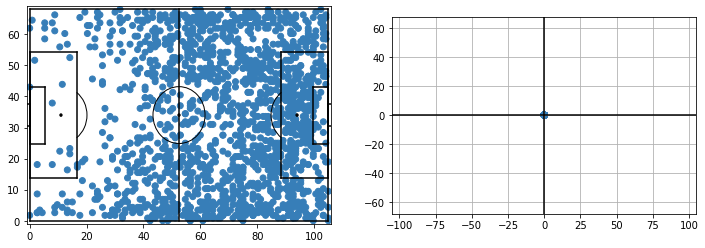

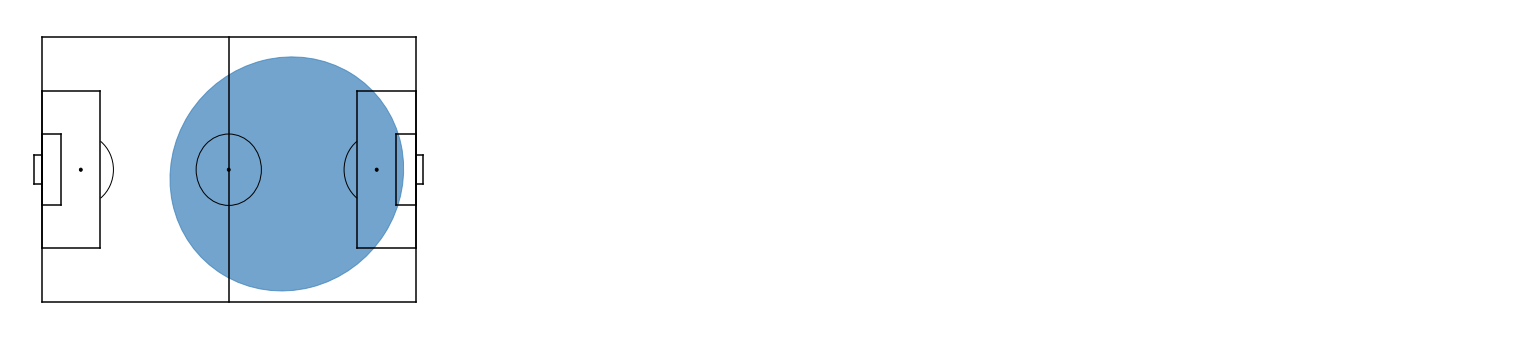

clearance 1 3336


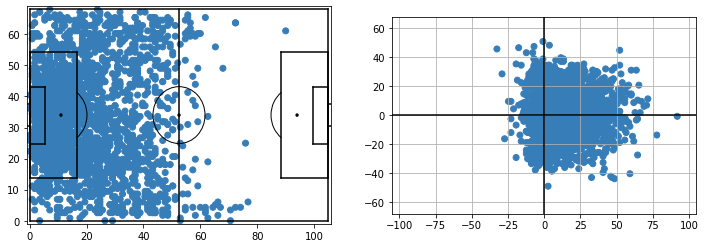

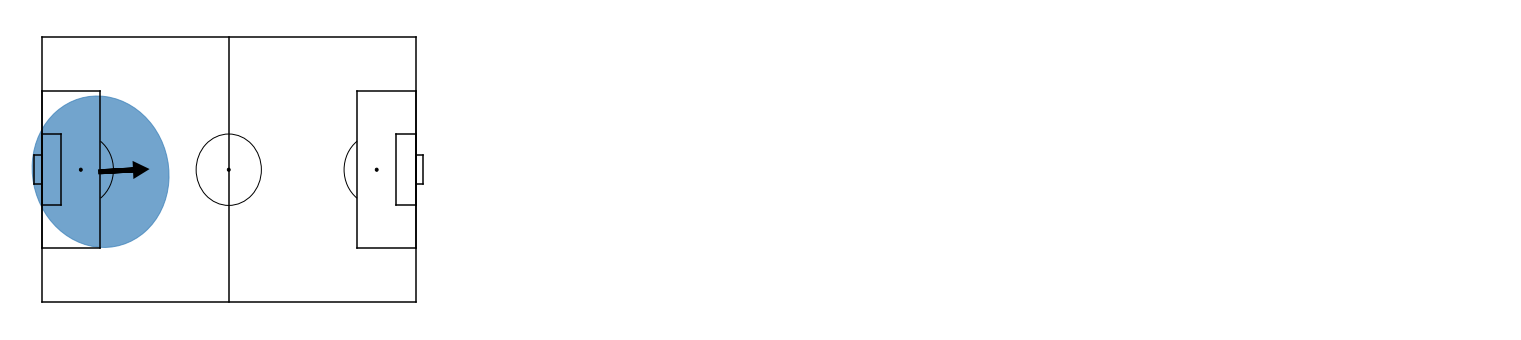

corner 2 650


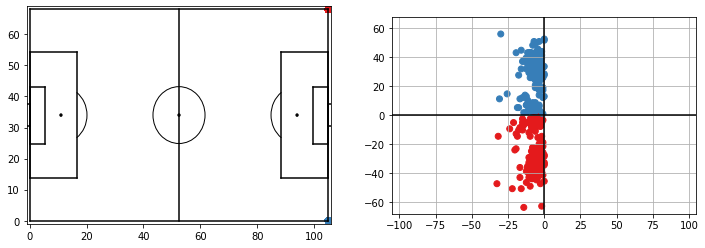

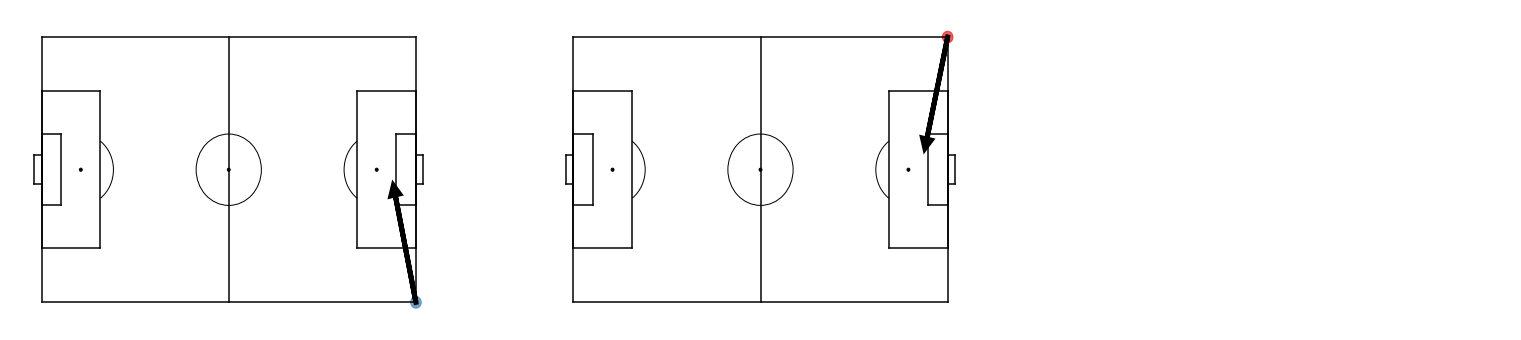

cross 2 1340


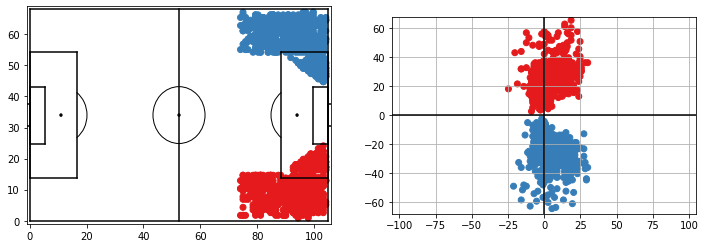

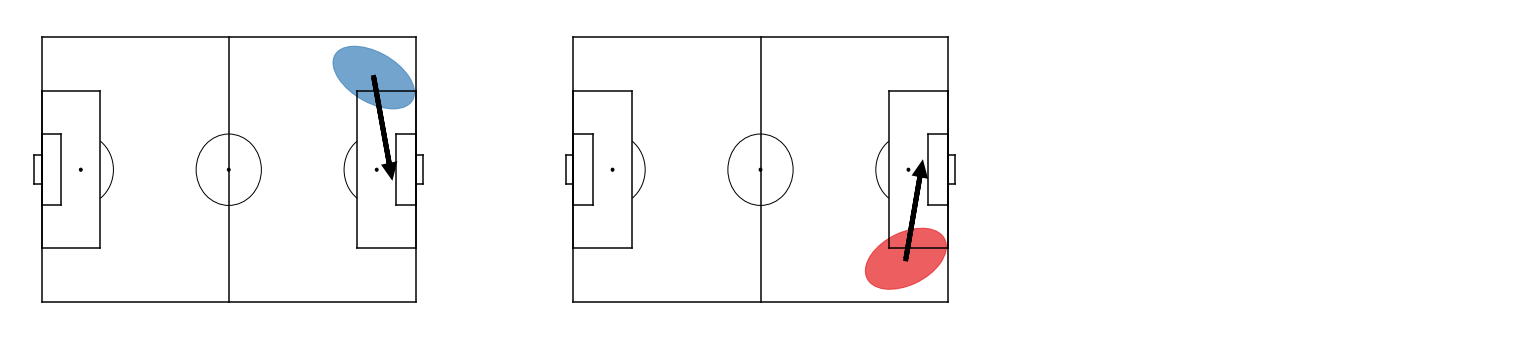

dribble 22 55786


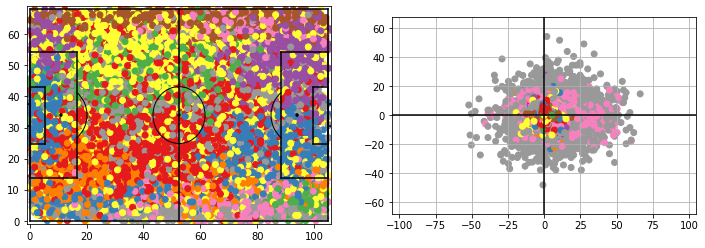

foul 1 1522


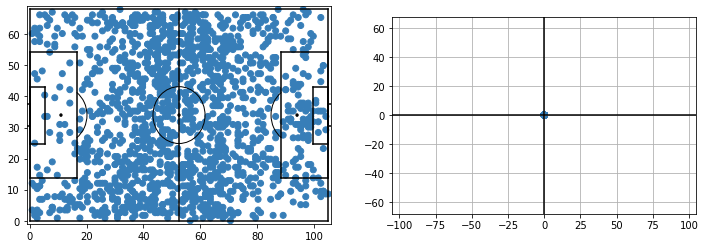

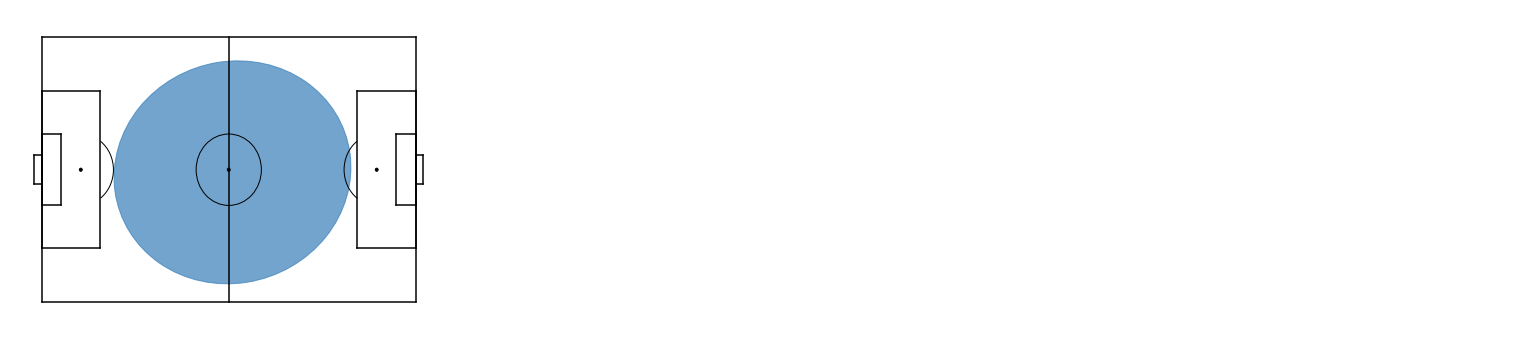

freekick 3 1485


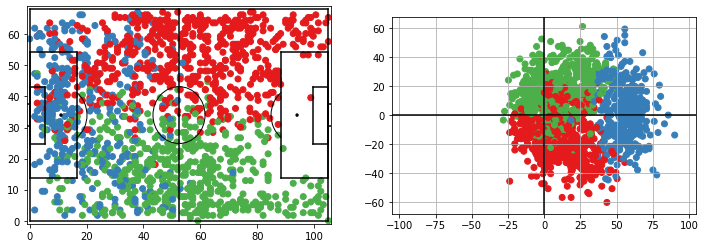

goal 1 181


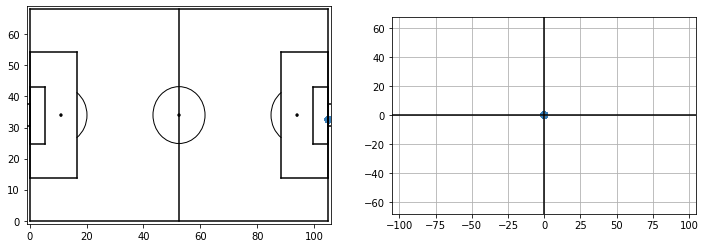

goalkick 1 957


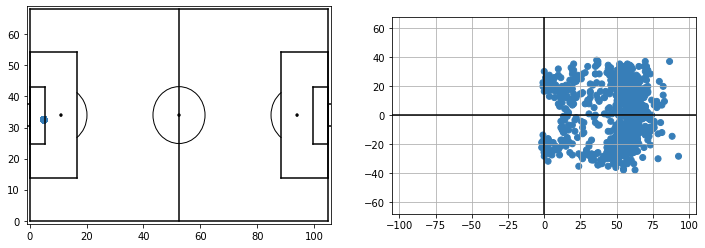

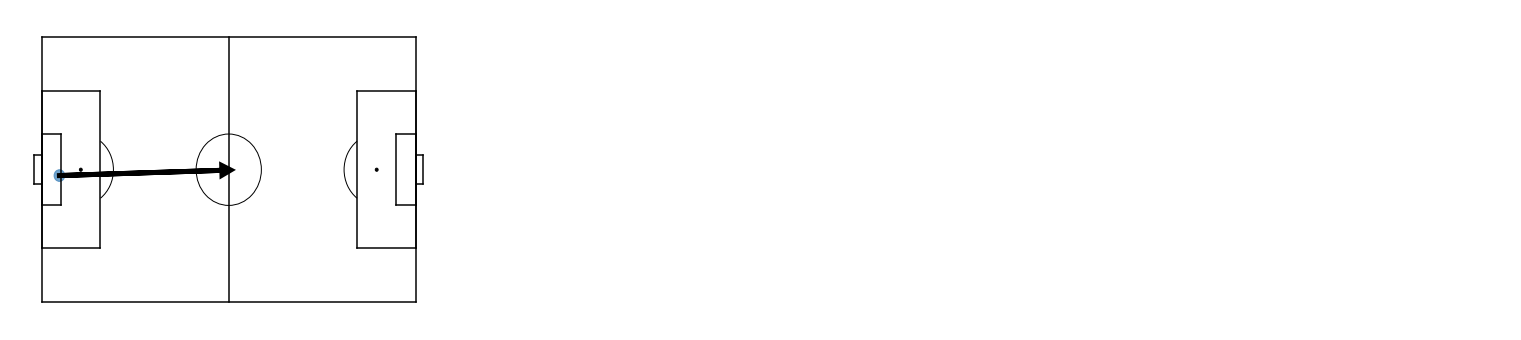

interception 7 12753


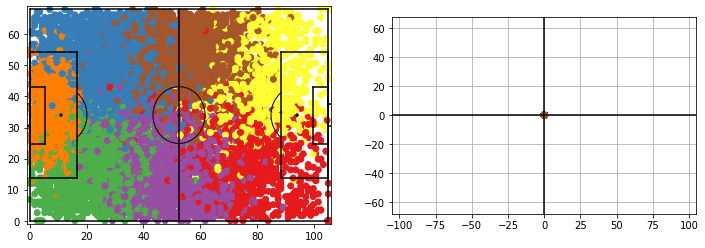

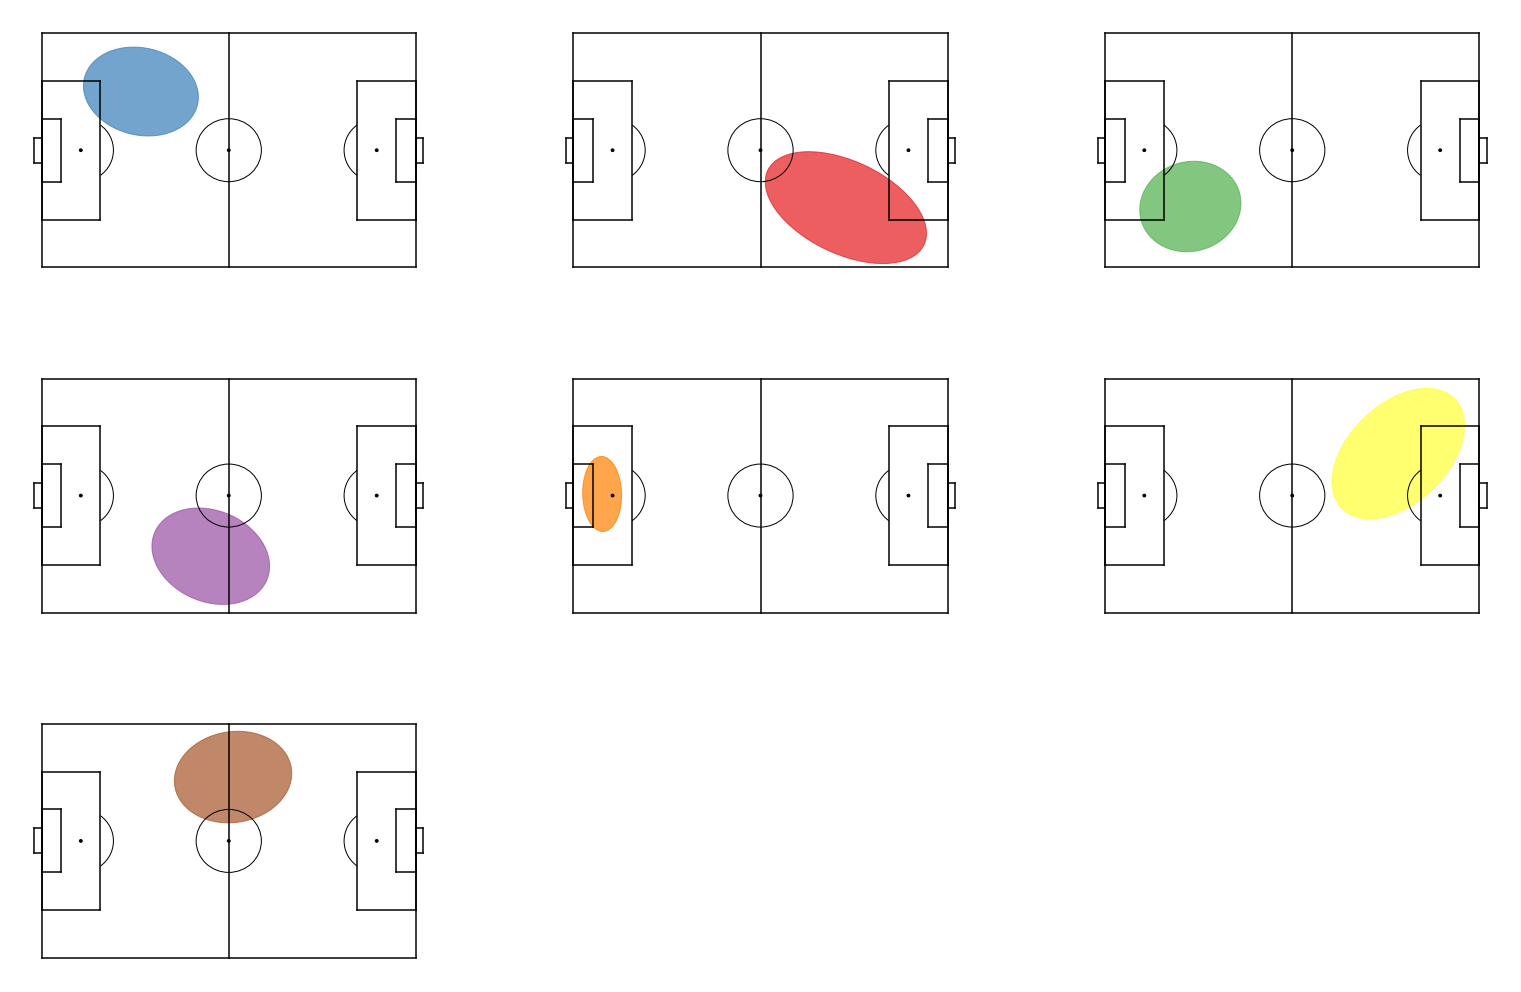

keeper_catch 1 641


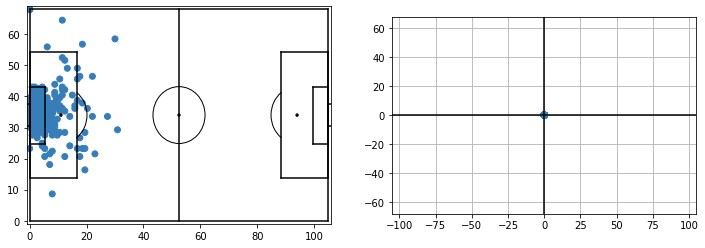

offside 1 207


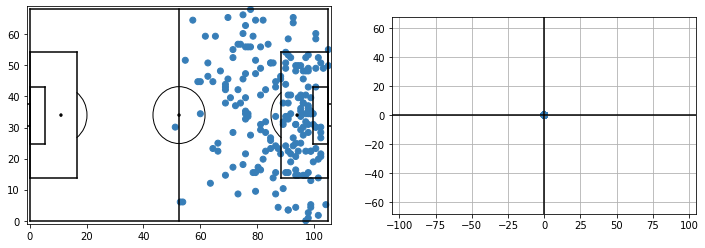

out 3 2555


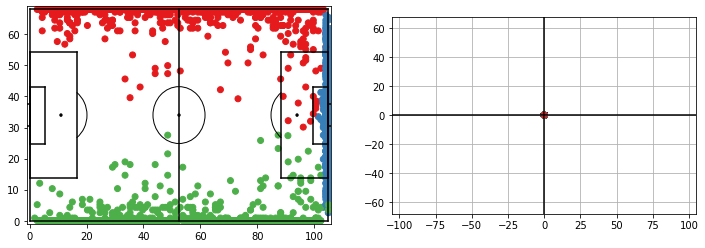

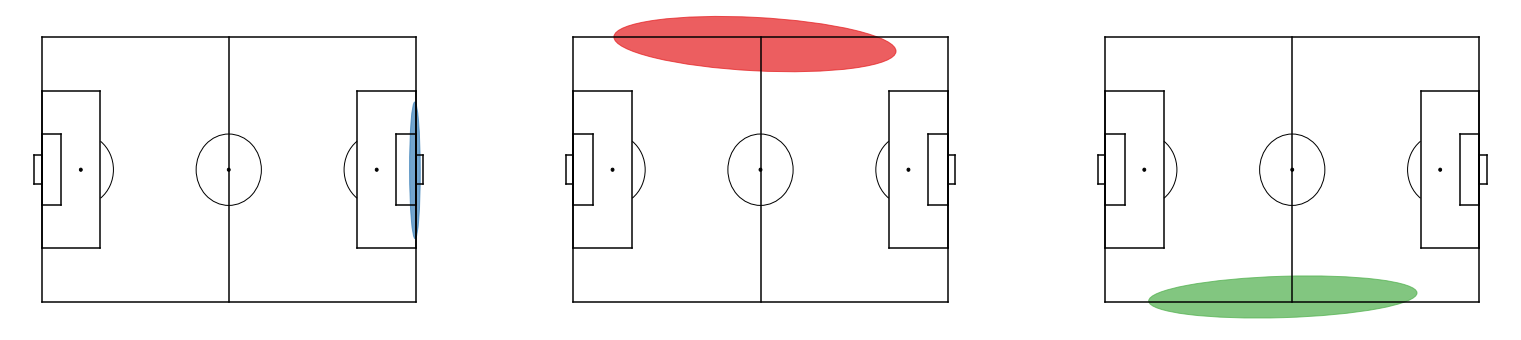

owngoal 1 2


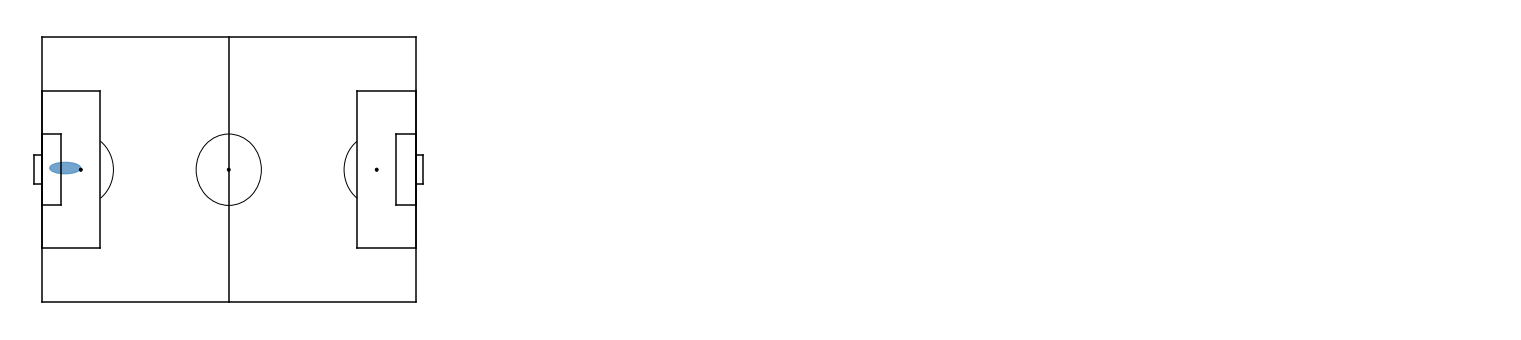

pass 22 56530


receival 18 51567


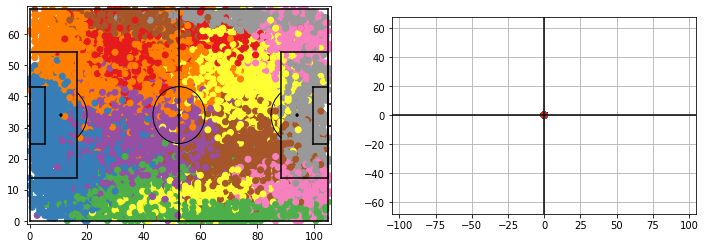

red_card 1 3


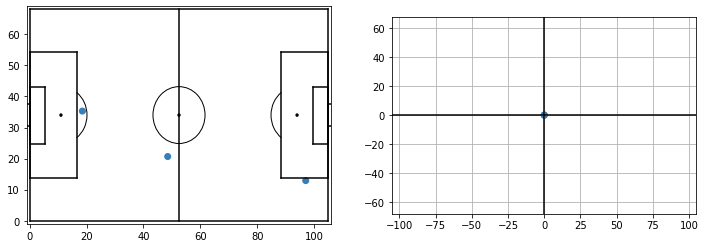

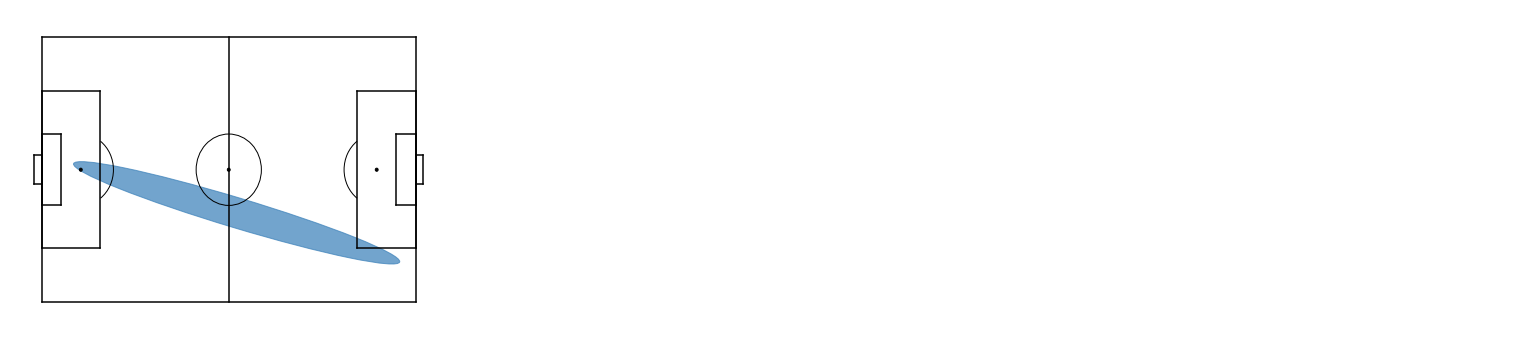

shot 1 1550


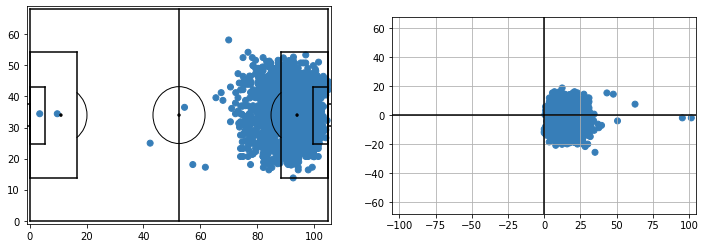

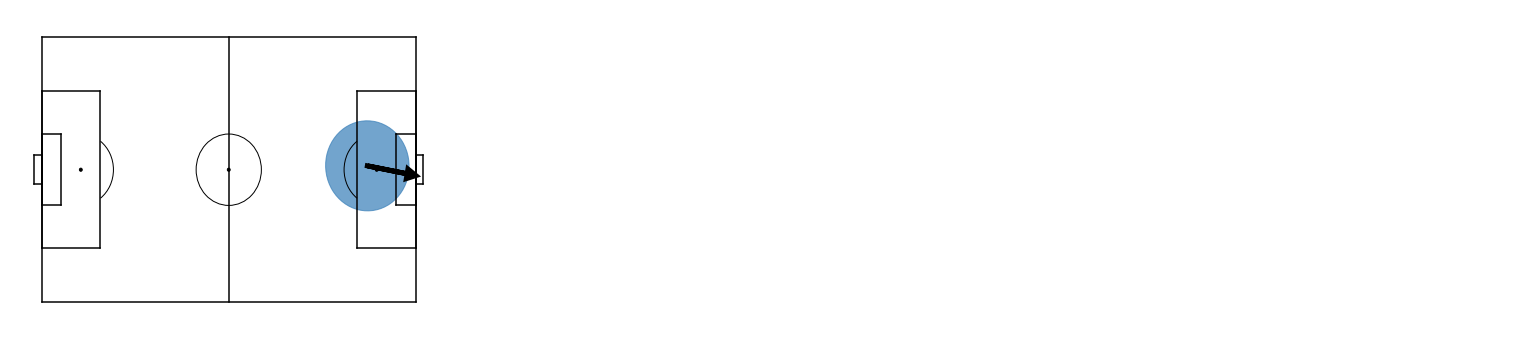

shot_penalty 1 19


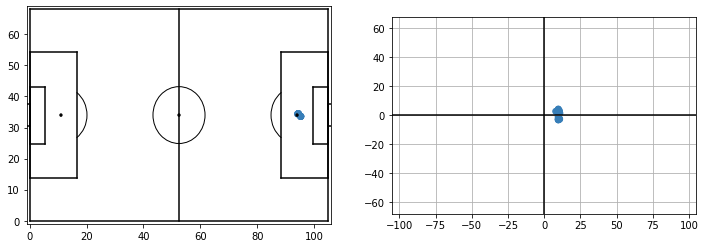

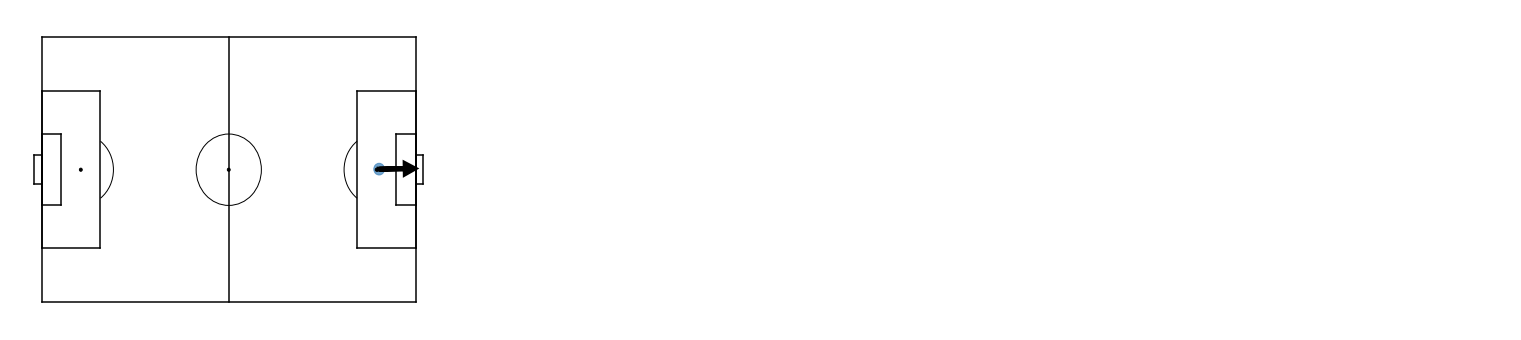

tackle 3 2281


take_on 3 2112


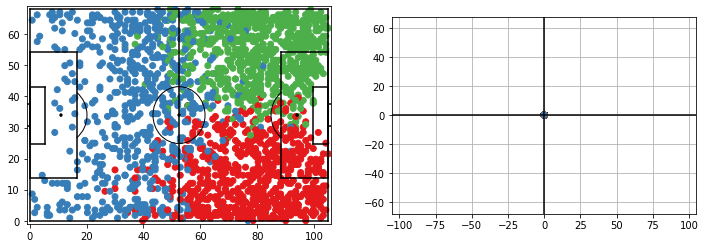

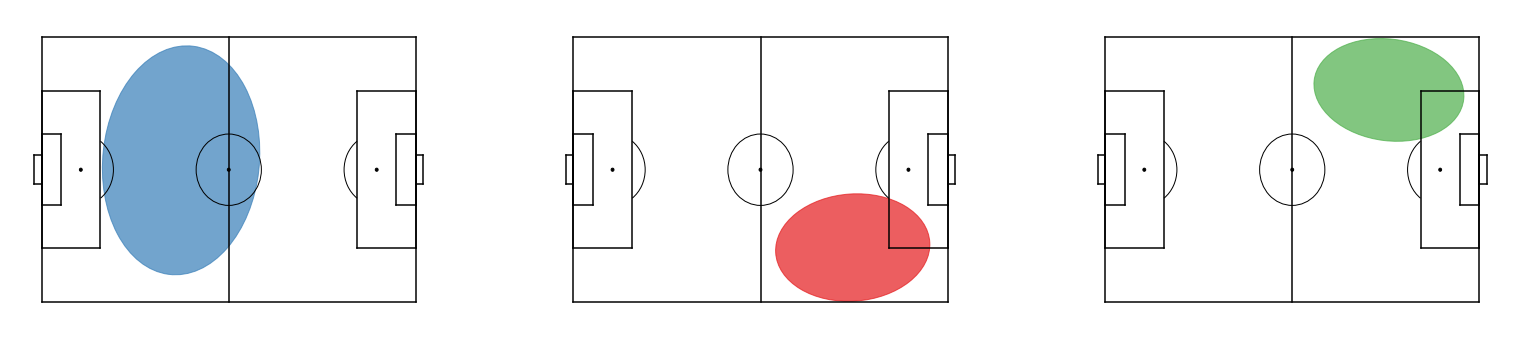

throw_in 3 2733


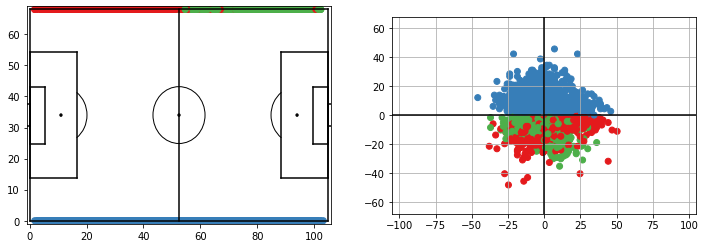

../pattern/vis.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


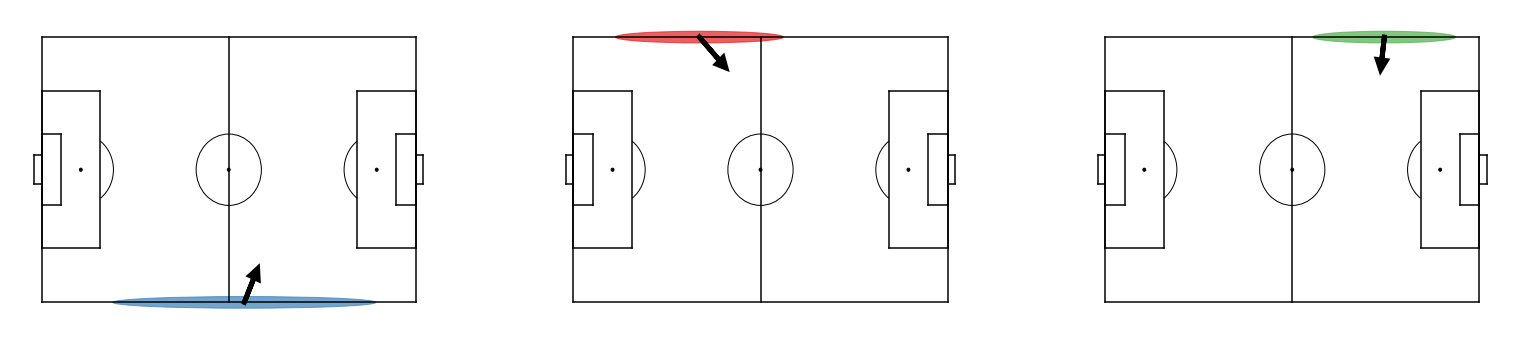

yellow_card 1 185


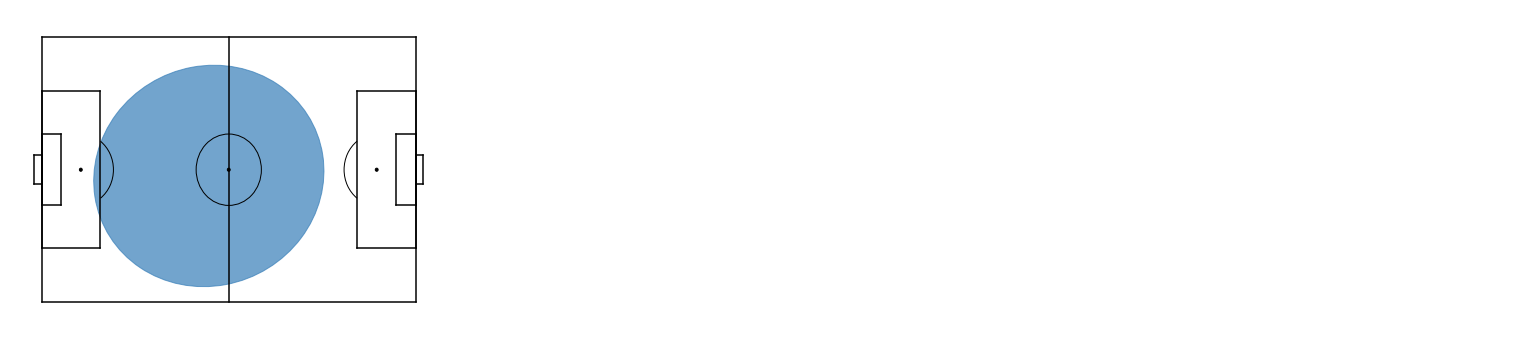

In [257]:
import pattern.vis as vis
for k, gmm in sorted(list(gmme.models.items())):
    df = a[a.type_name == k]
    print(k,gmm.n_components,len(df))
    #vis.plot_gmm(gmm)
    vis.plot_gmm_actions(gmm,df,gmme.cols,samplefn="uni")
    vis.plot_components_arrows(gmm,cols=3)

In [249]:
probas = gmme.predict_proba(a)

corner1


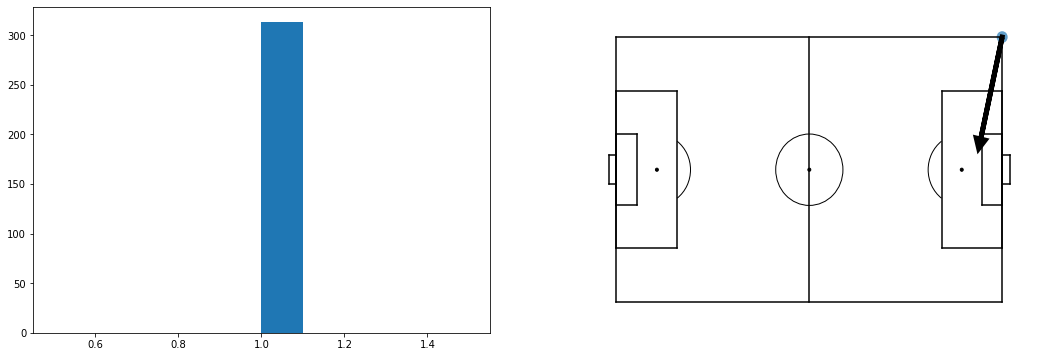

corner2


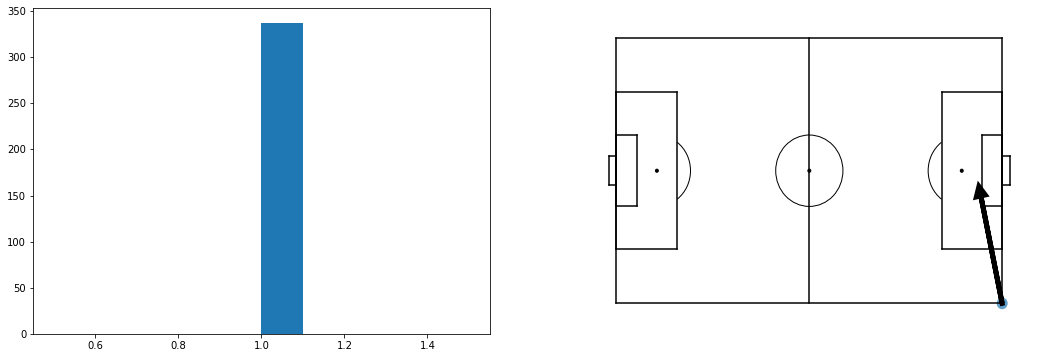

offside1


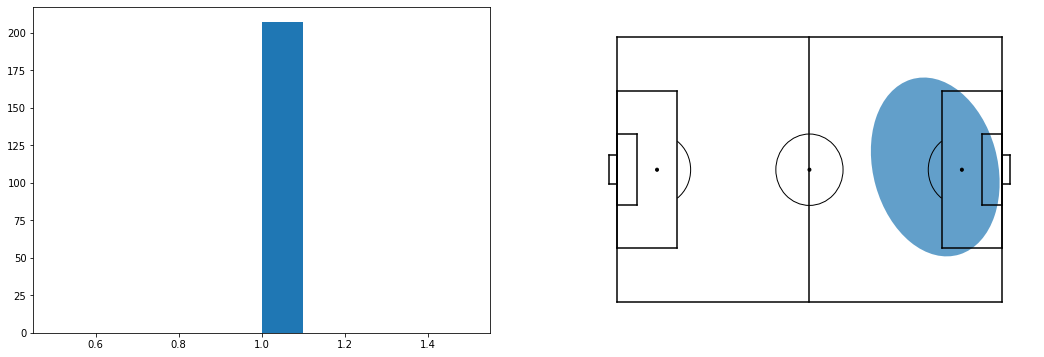

interception1


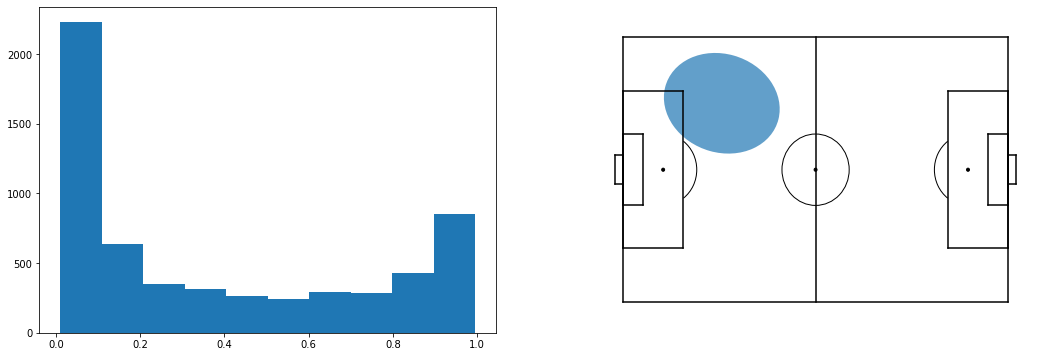

interception2


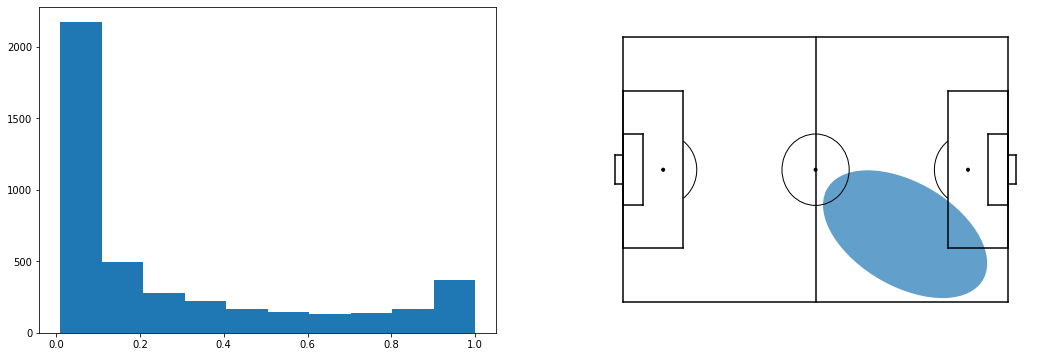

interception3


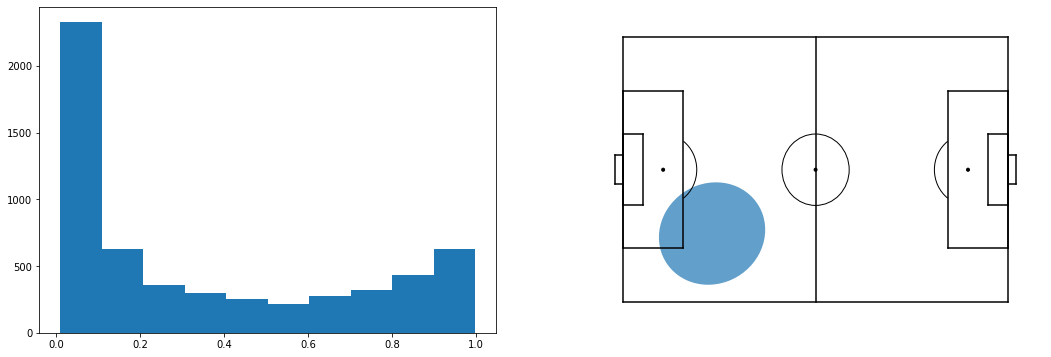

interception4


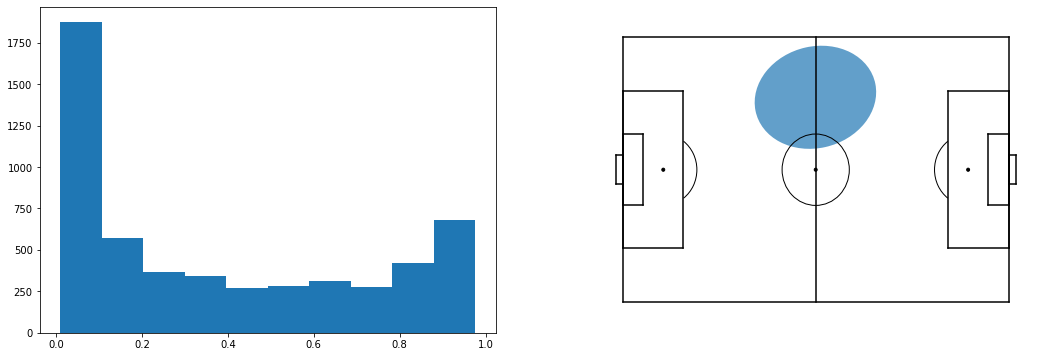

interception5


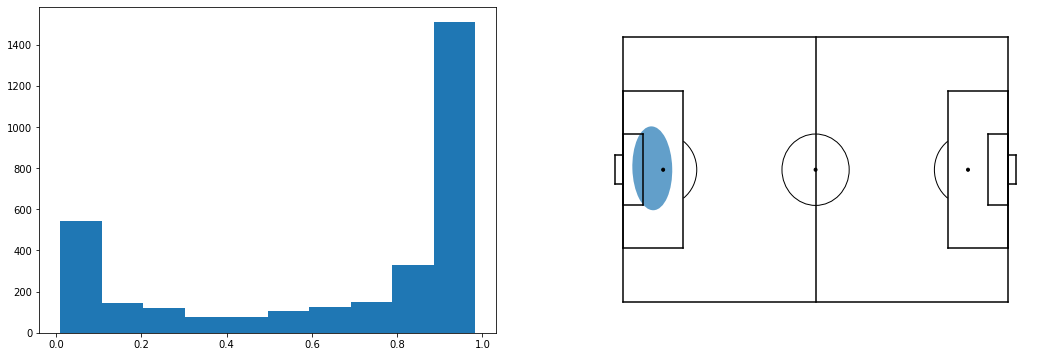

interception6


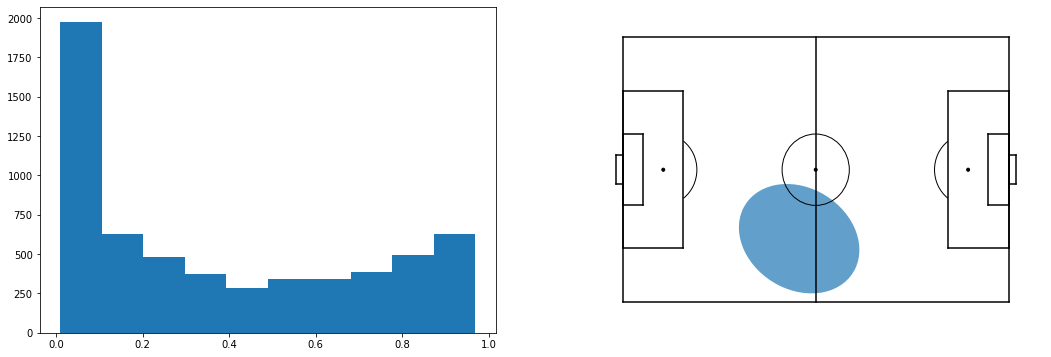

interception7


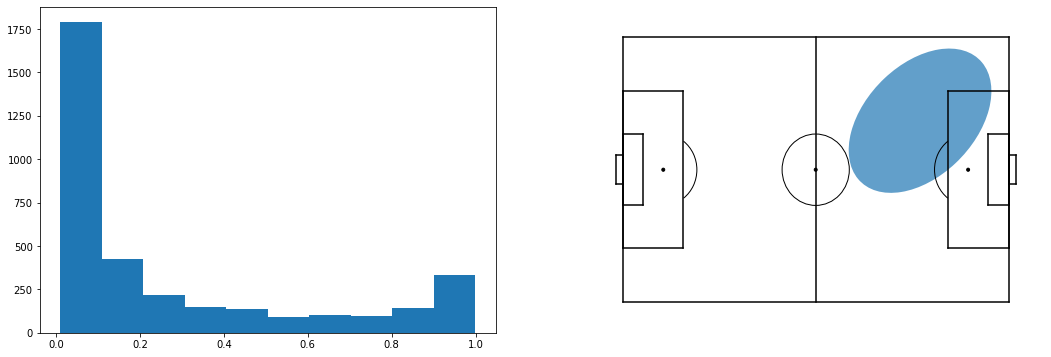

tackle1


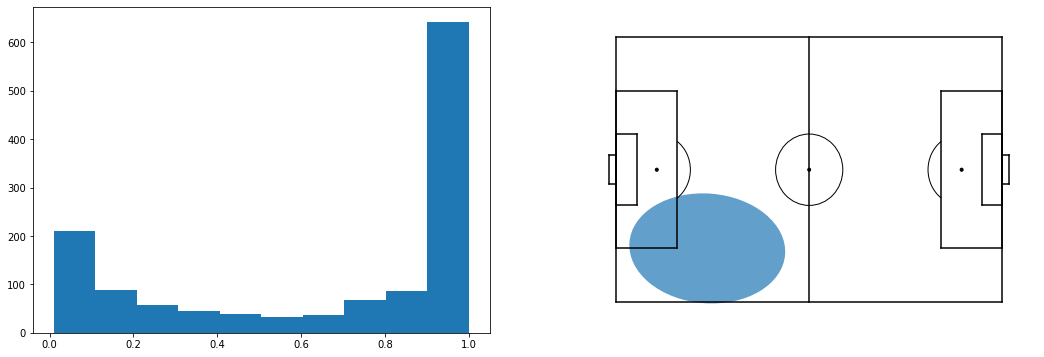

tackle2


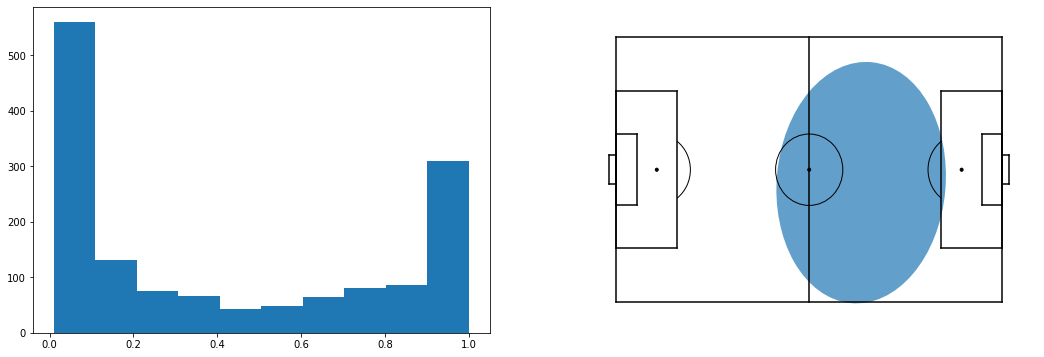

tackle3


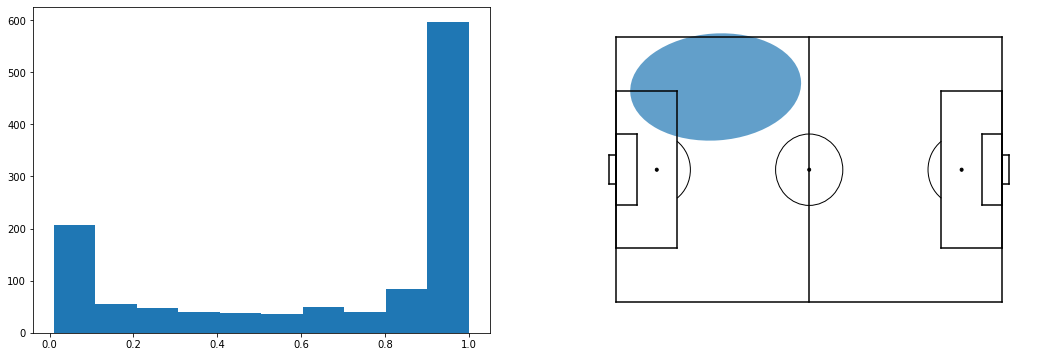

red_card1


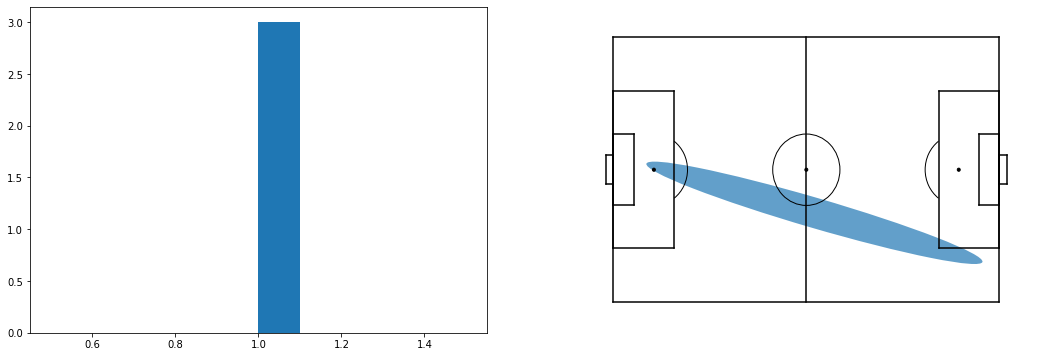

cross1


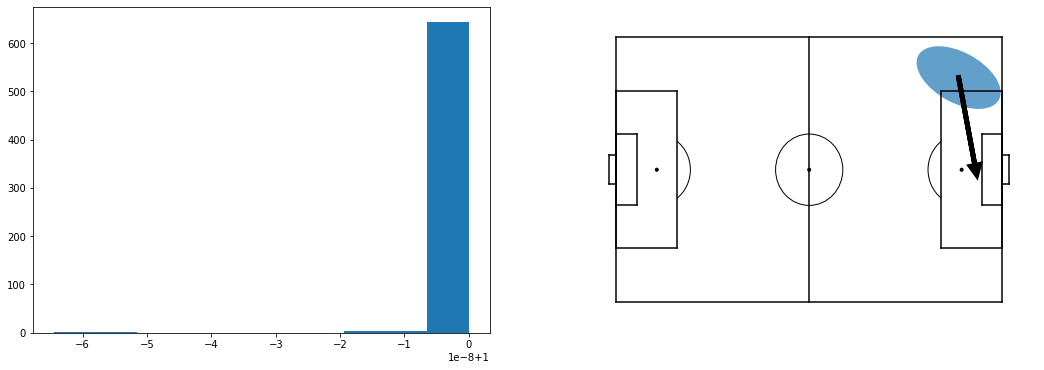

cross2


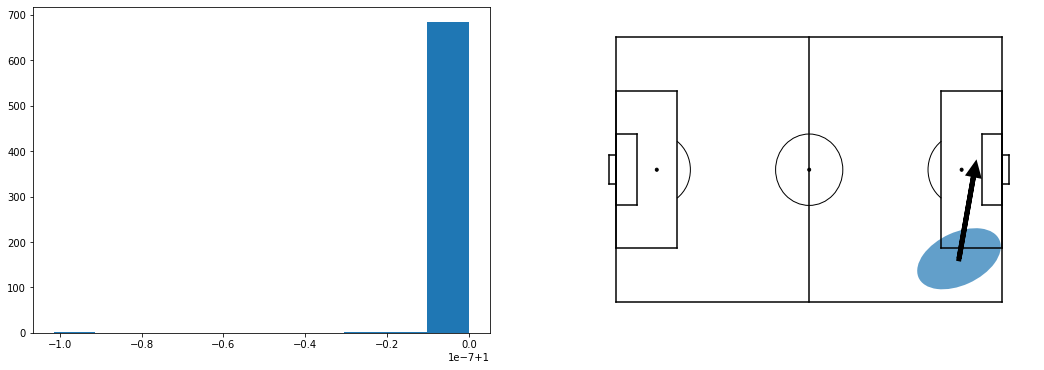

pass1


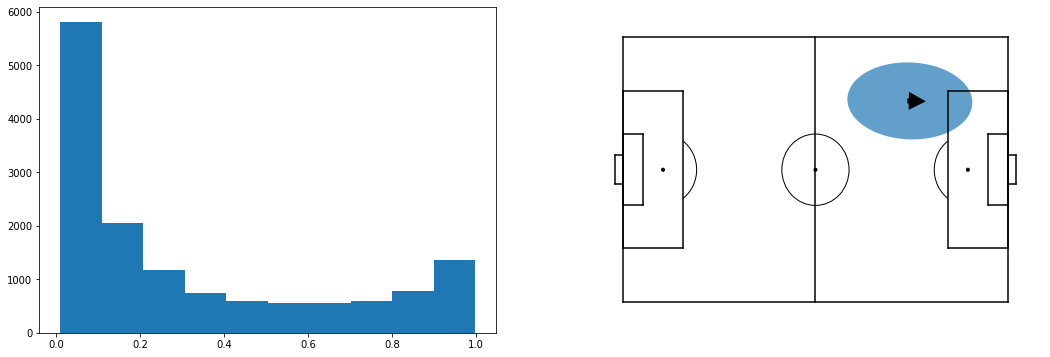

pass2


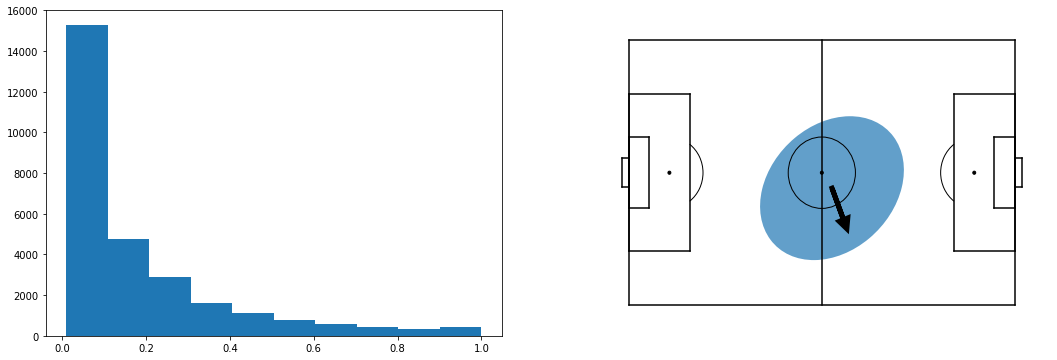

pass3


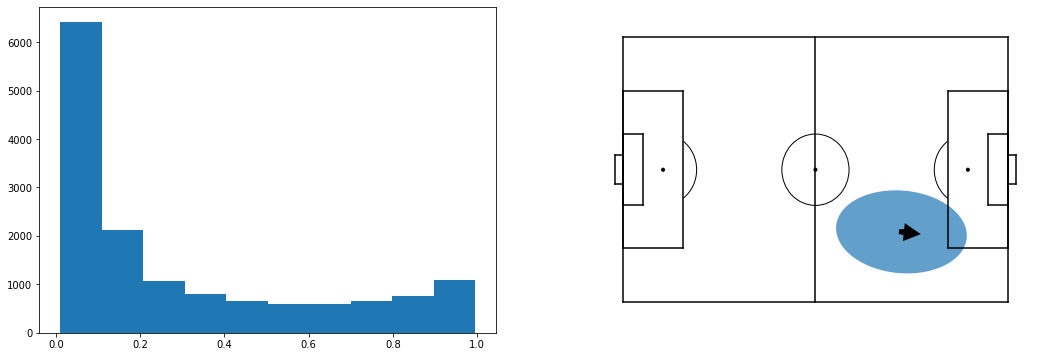

pass4


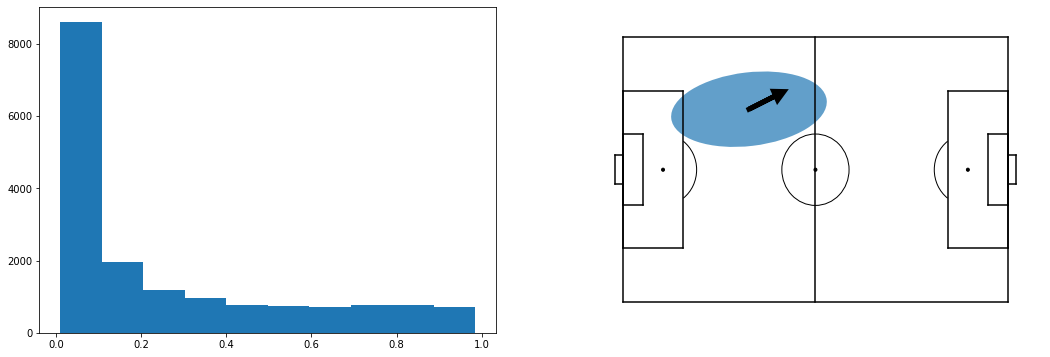

pass5


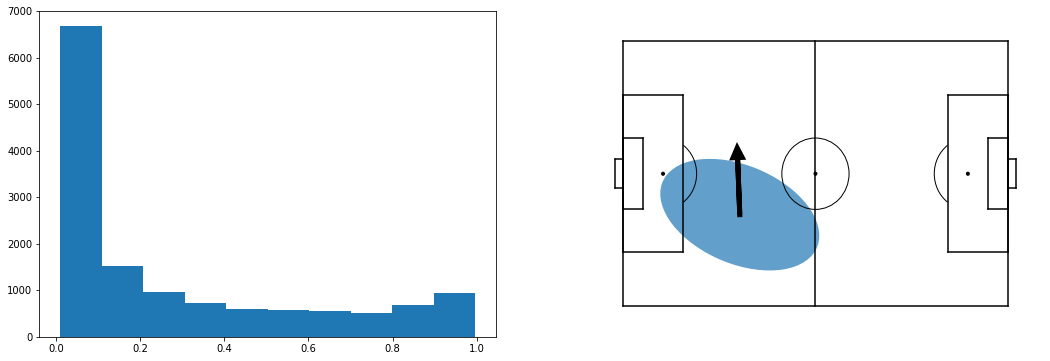

pass6


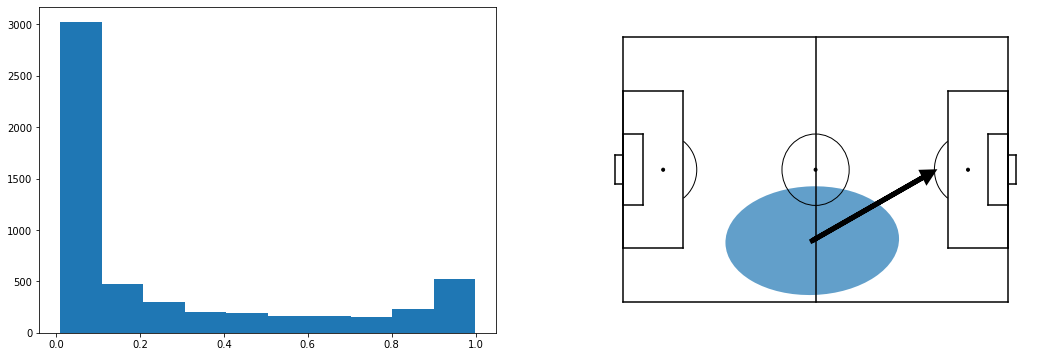

pass7


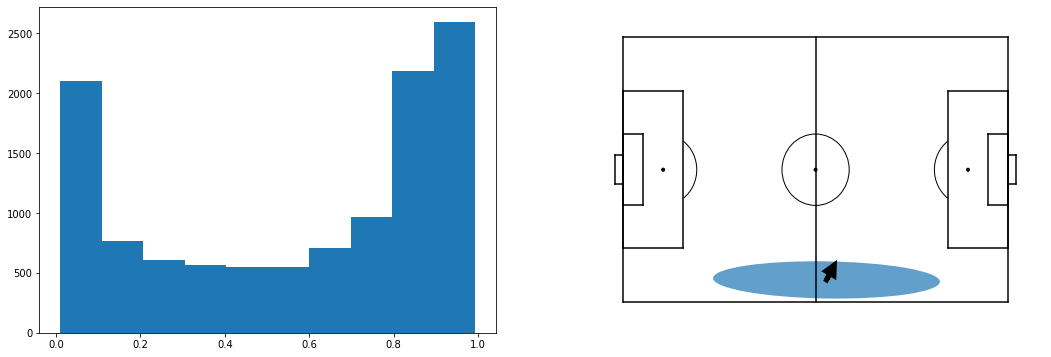

pass8


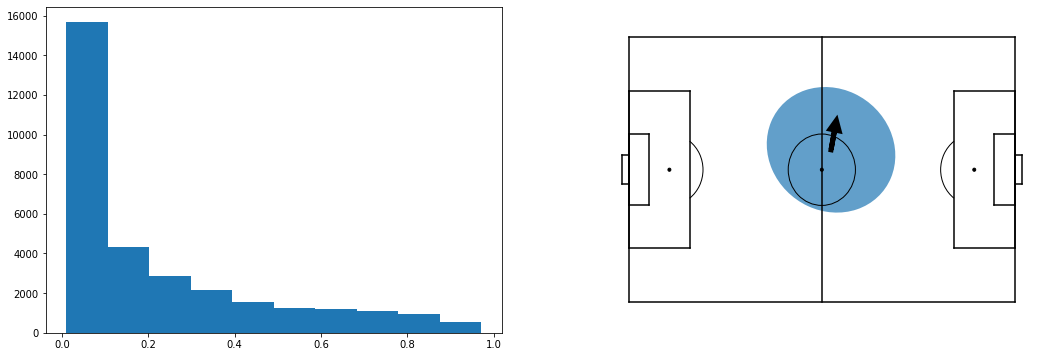

pass9


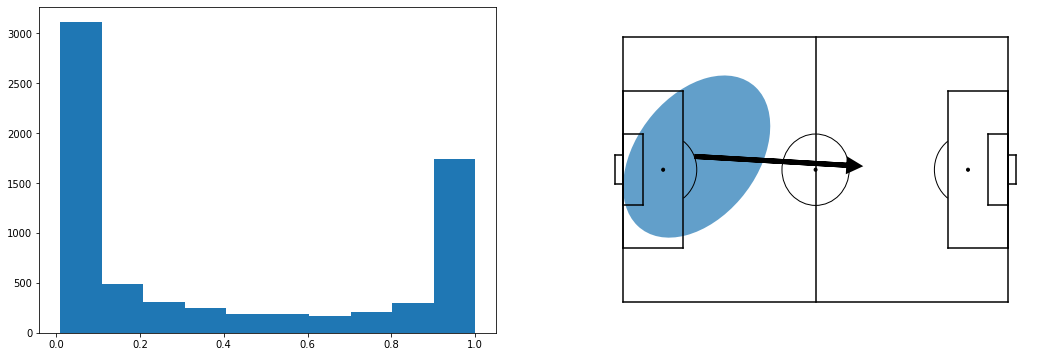

pass10


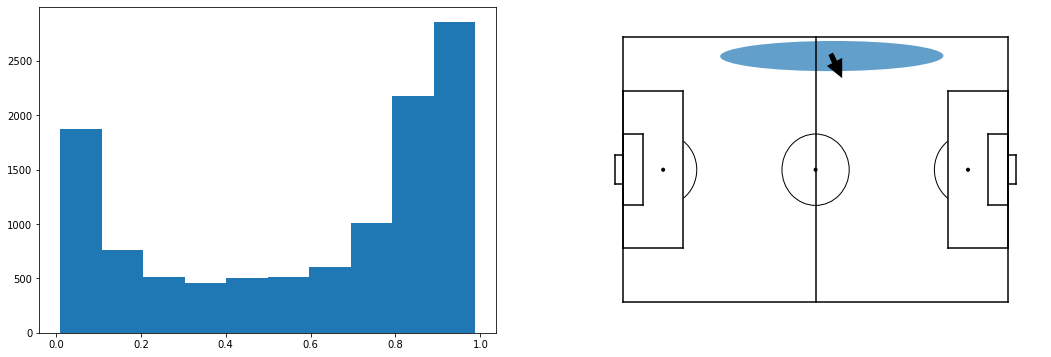

pass11


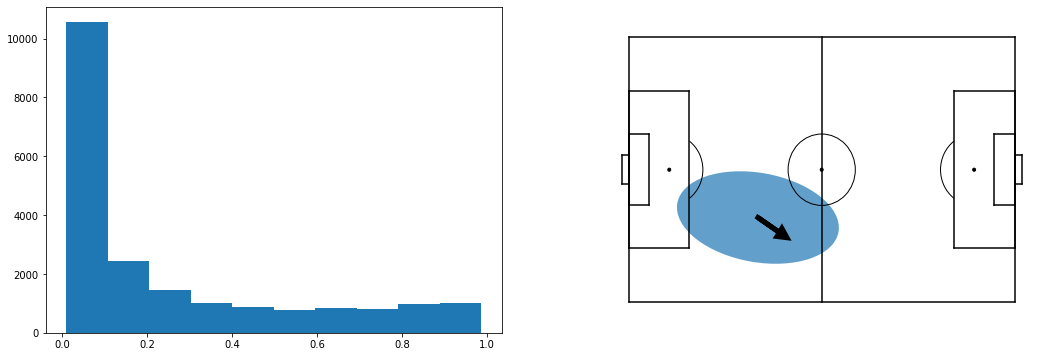

pass12


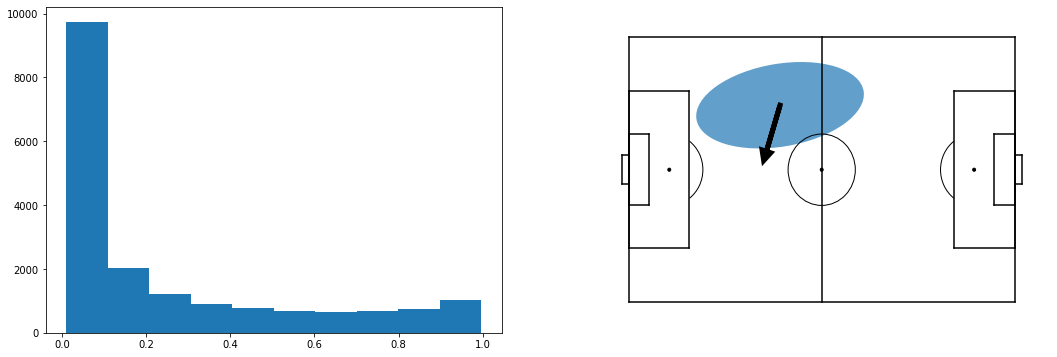

goal1


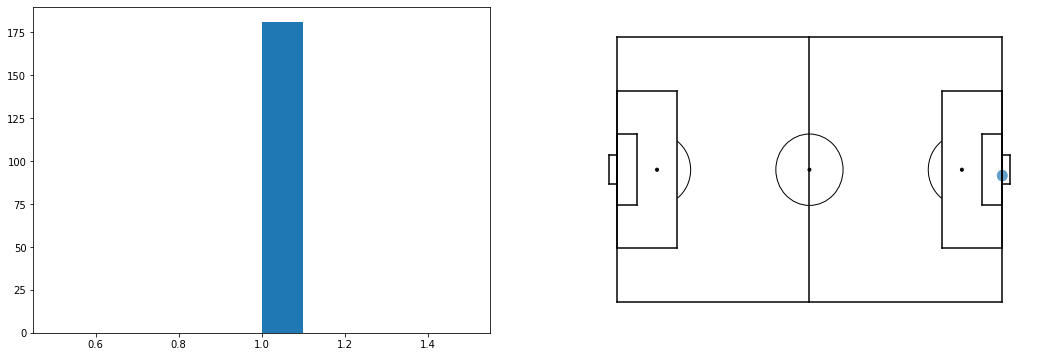

goalkick1


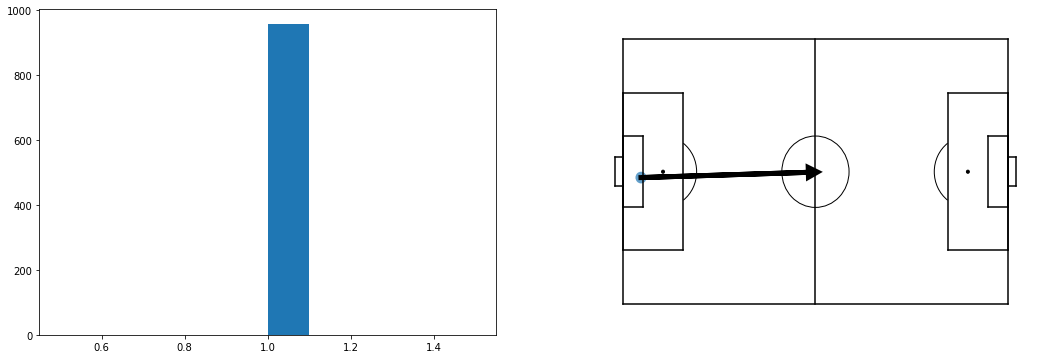

shot_penalty1


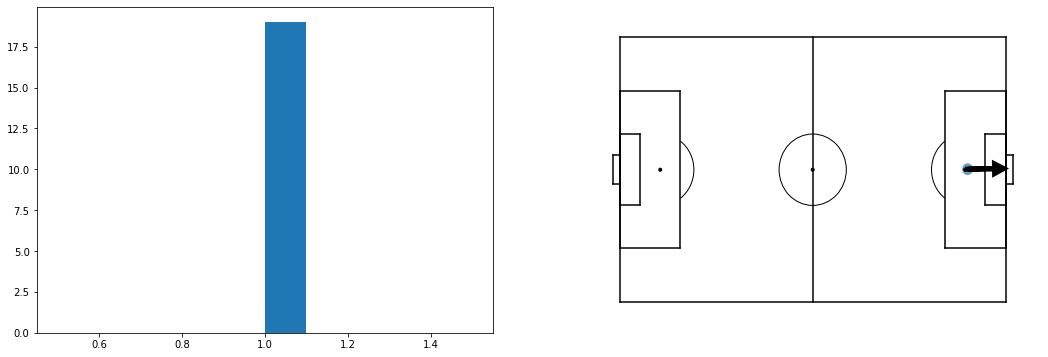

receival1


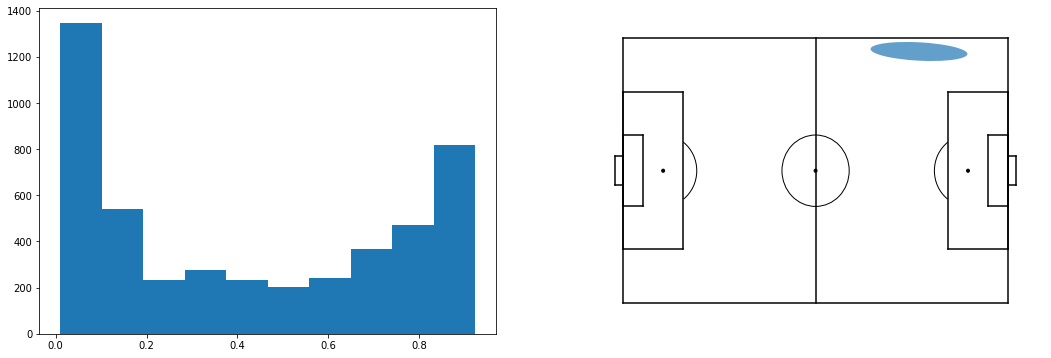

receival2


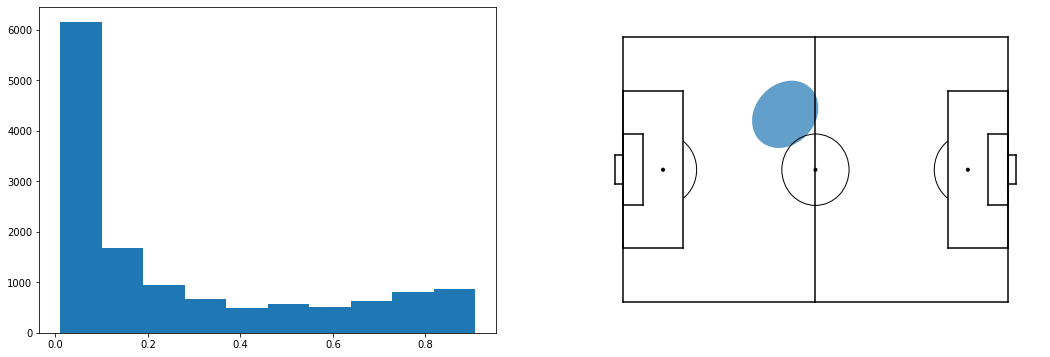

receival3


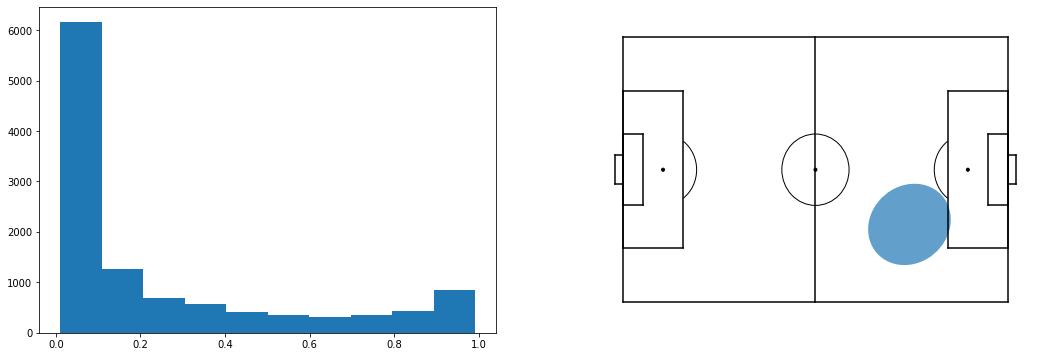

receival4


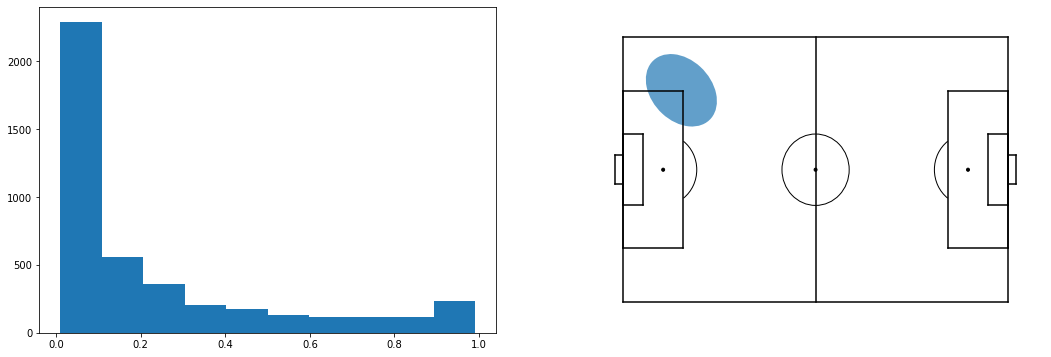

receival5


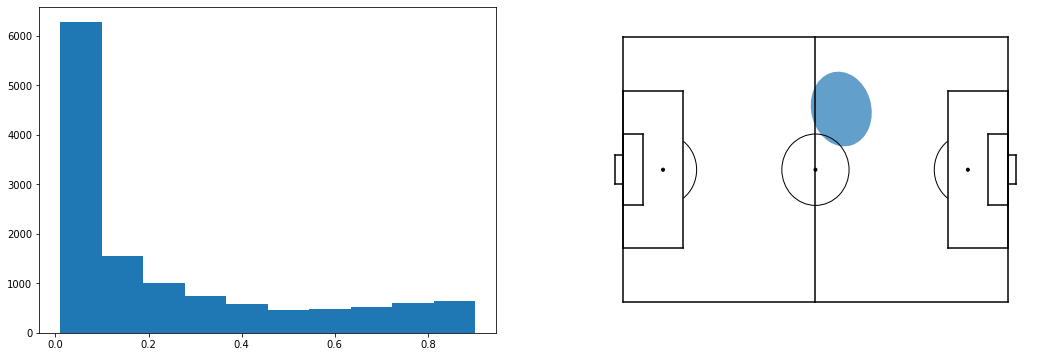

receival6


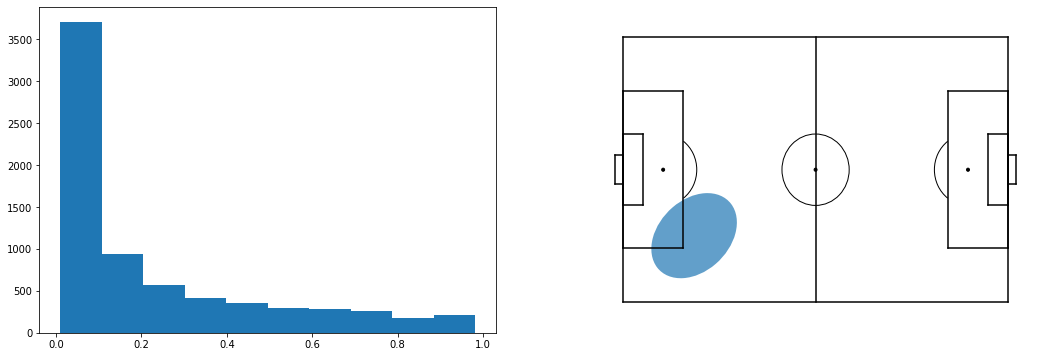

receival7


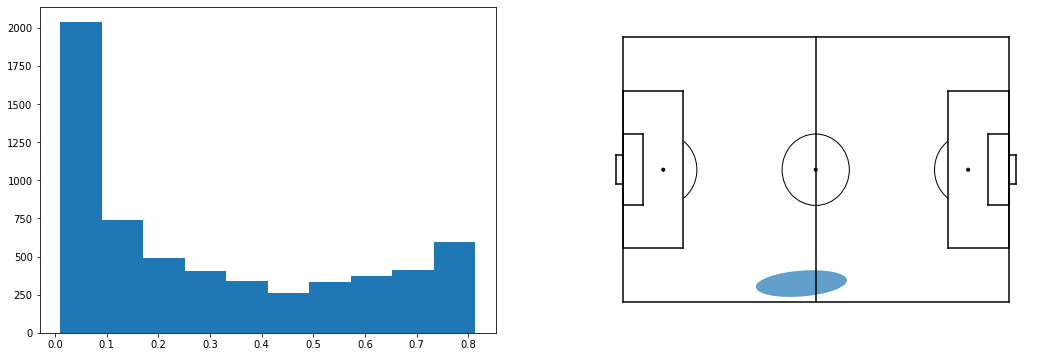

receival8


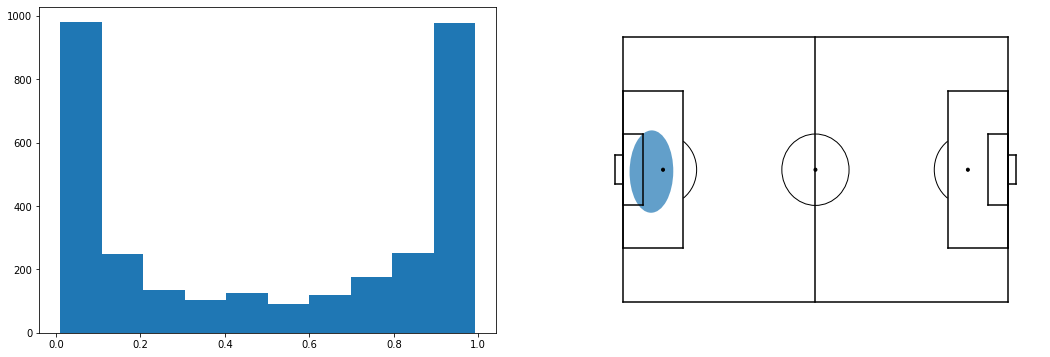

receival9


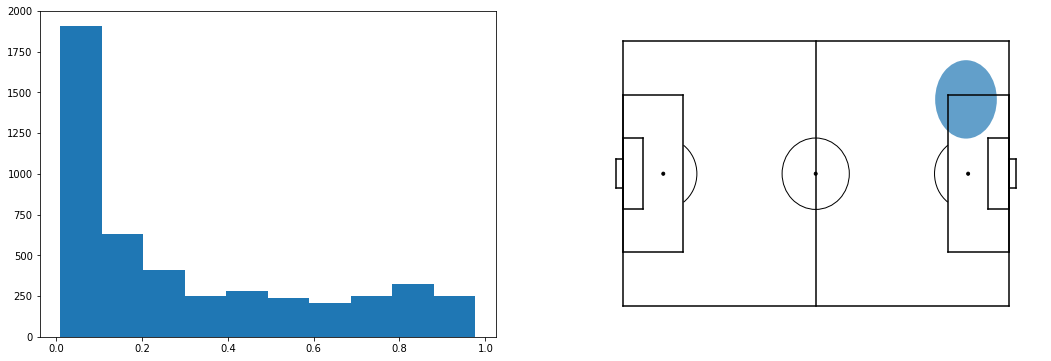

receival10


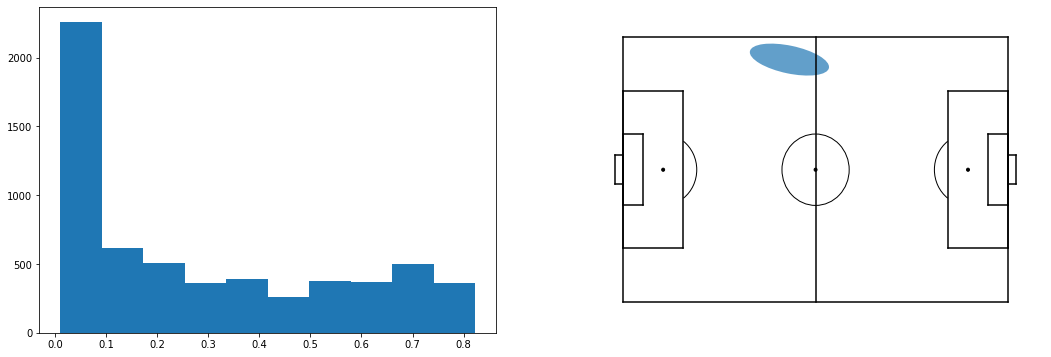

receival11


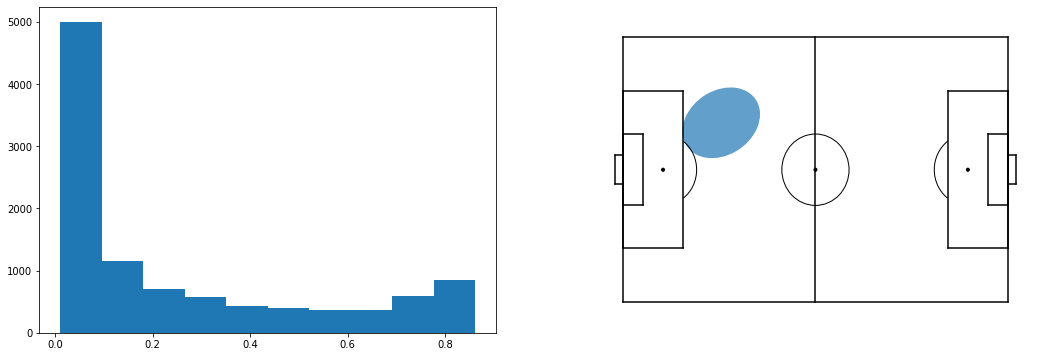

receival12


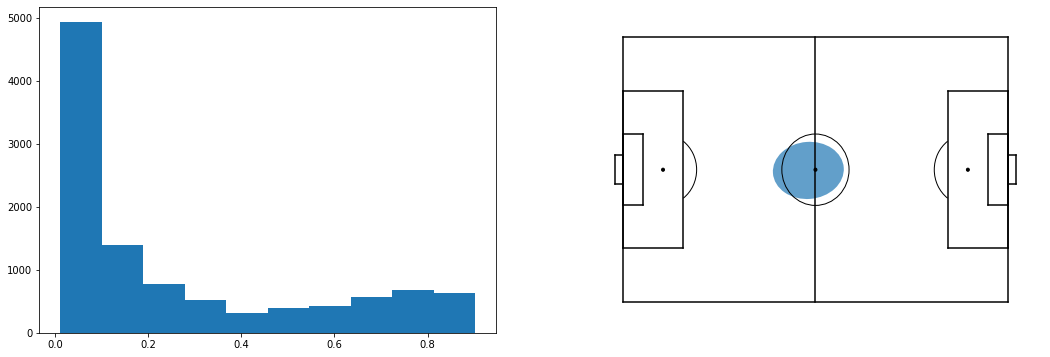

receival13


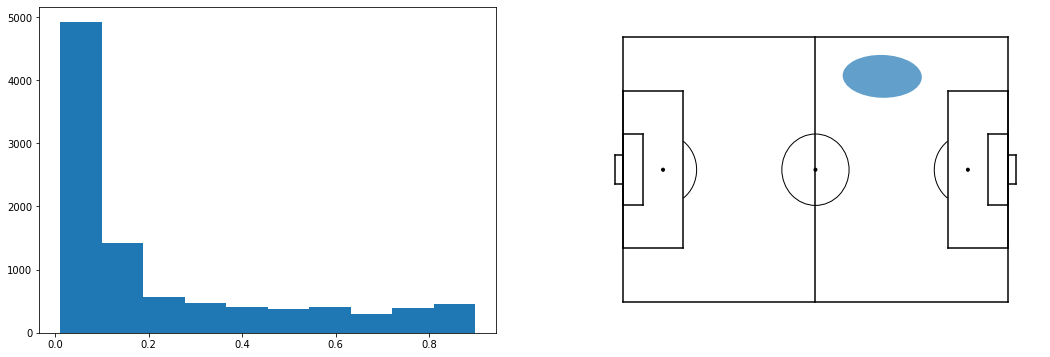

receival14


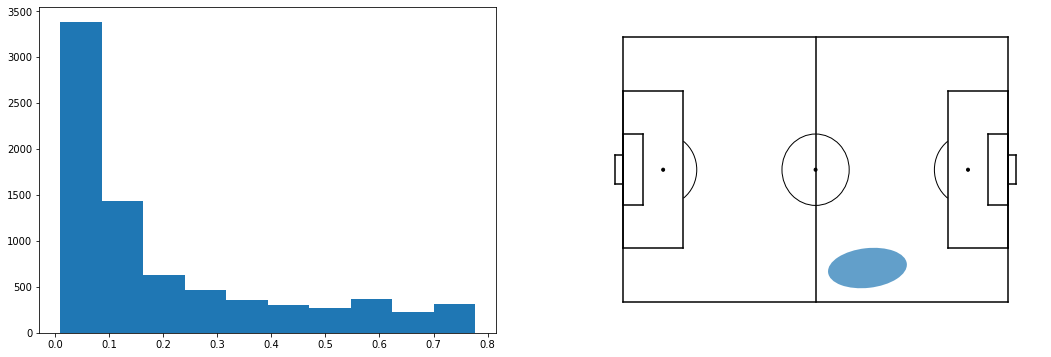

receival15


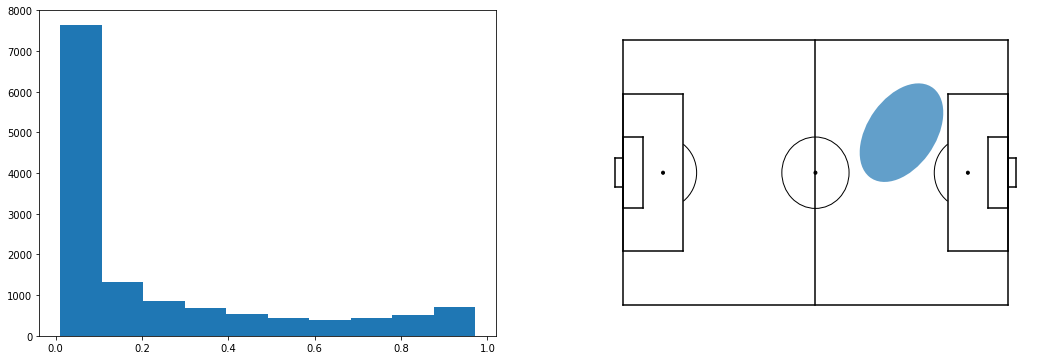

receival16


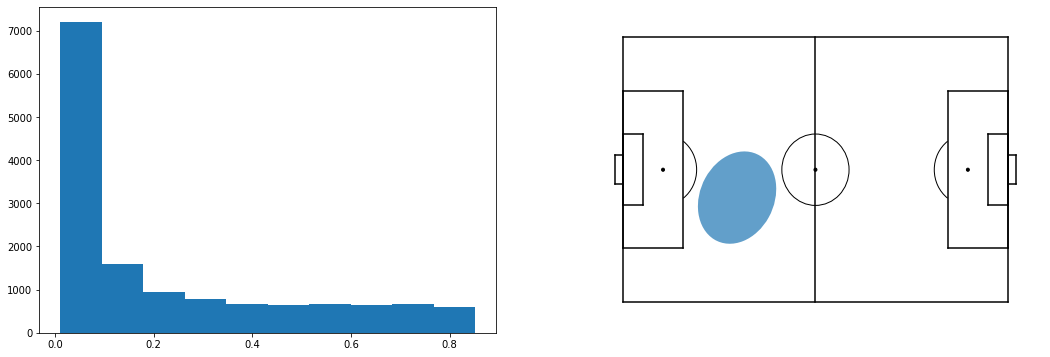

receival17


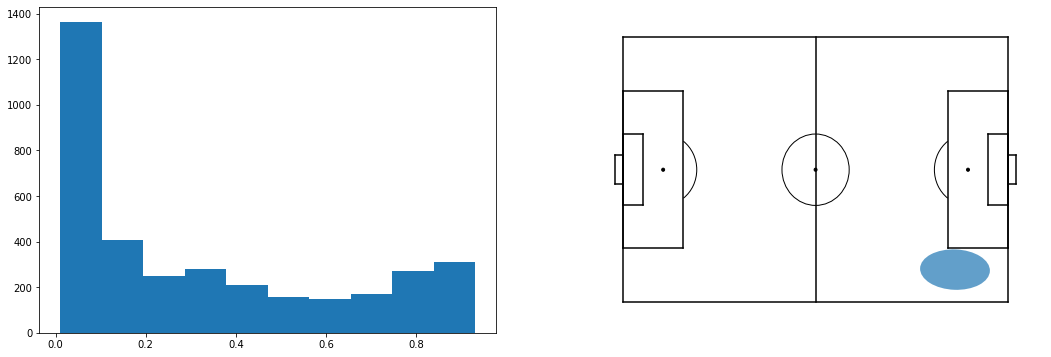

receival18


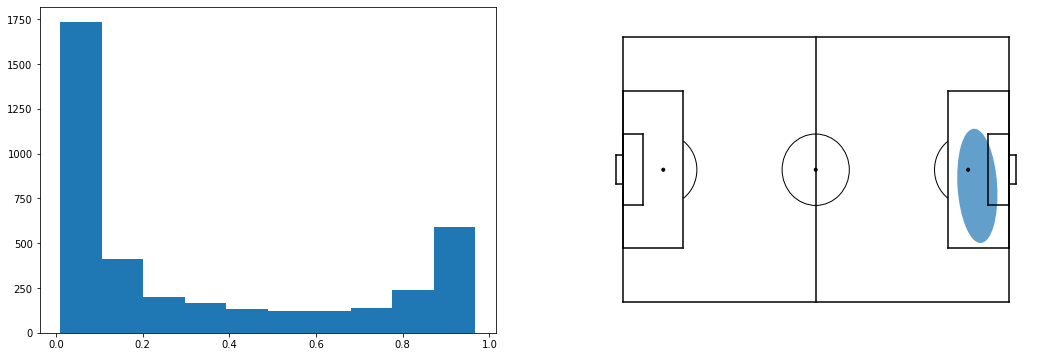

receival19


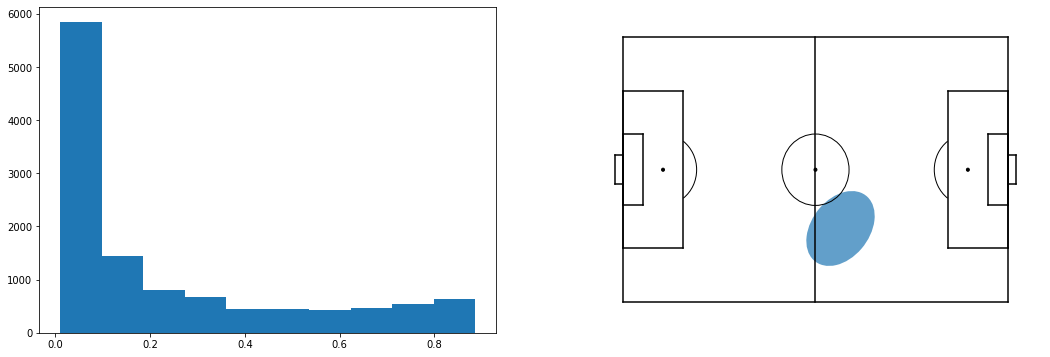

receival20


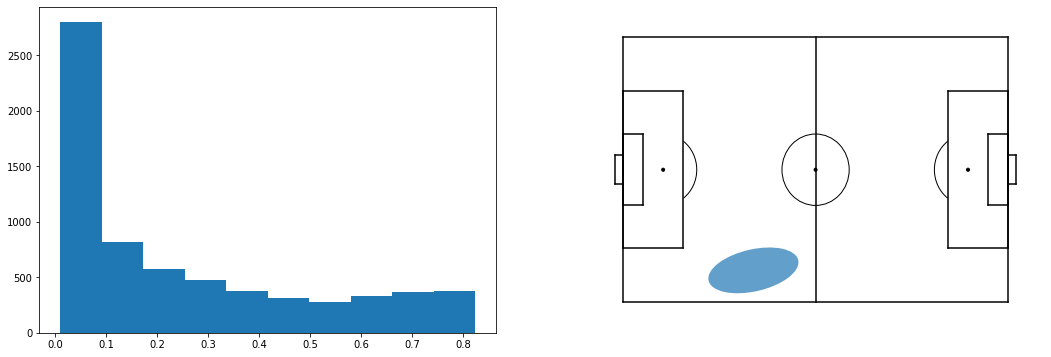

receival21


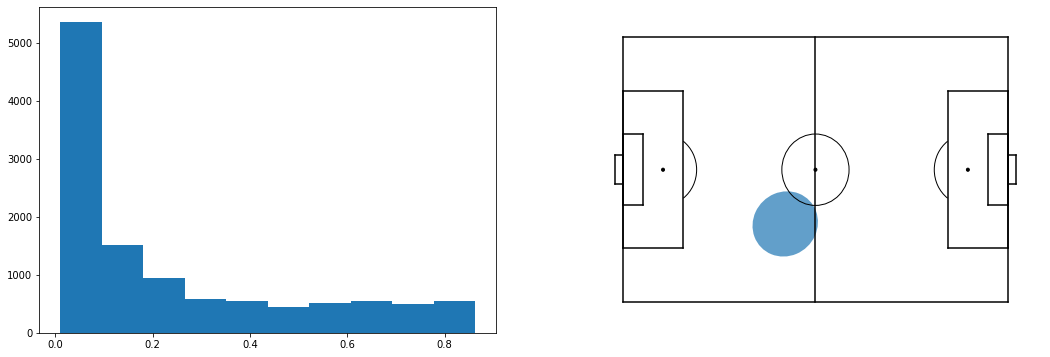

receival22


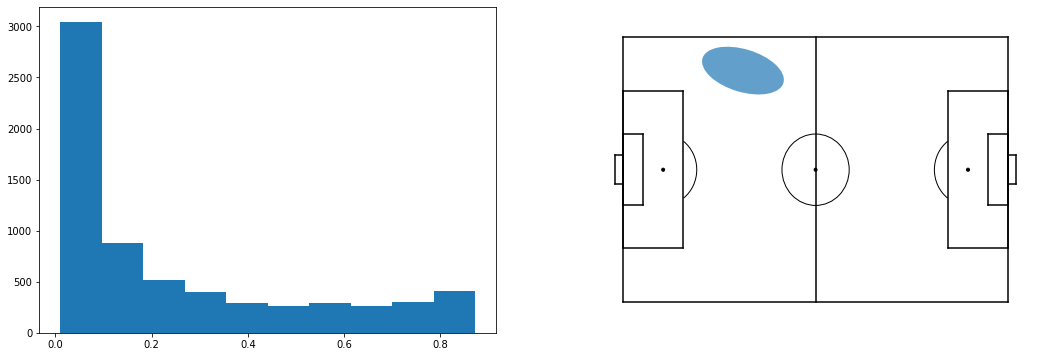

receival23


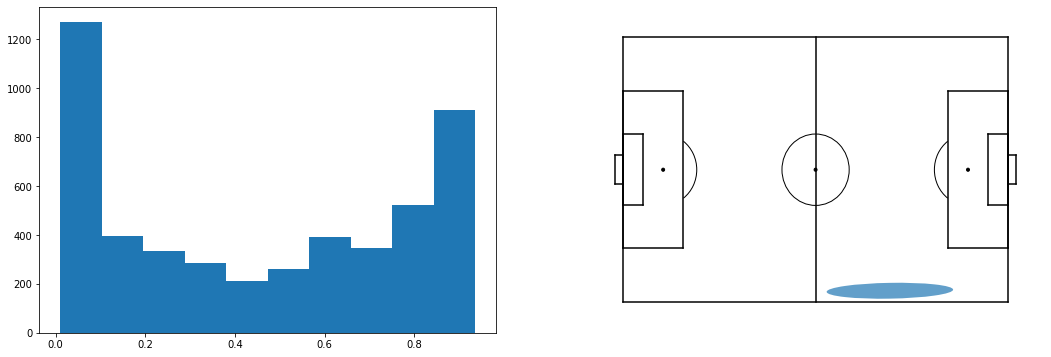

receival24


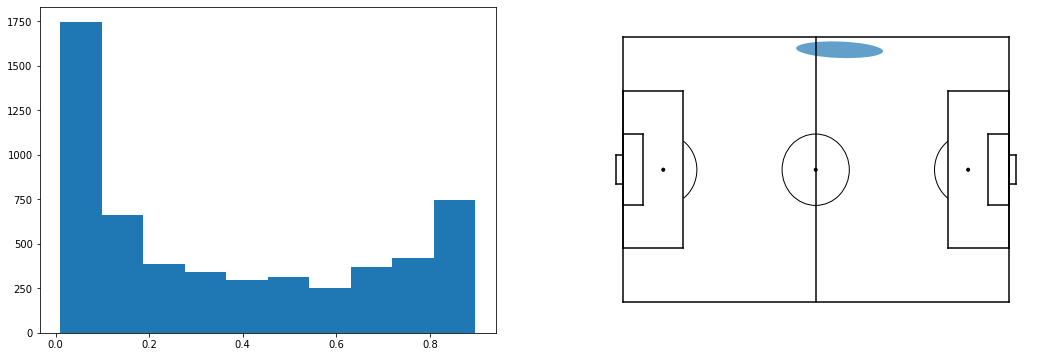

keeper_catch1


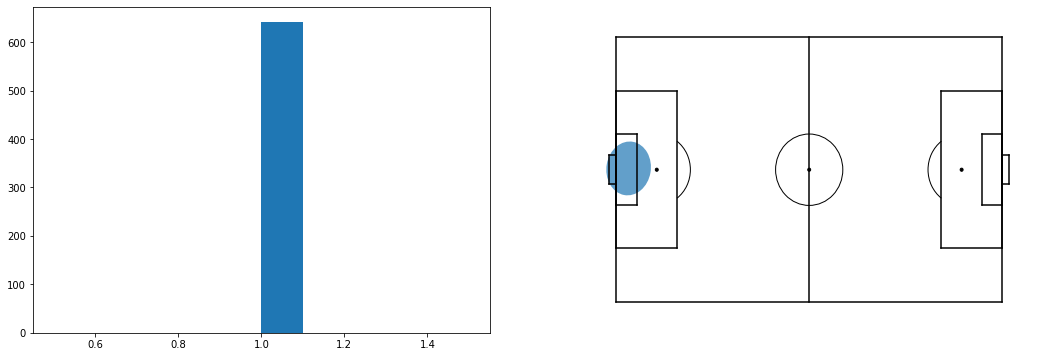

throw_in1


../pattern/vis.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


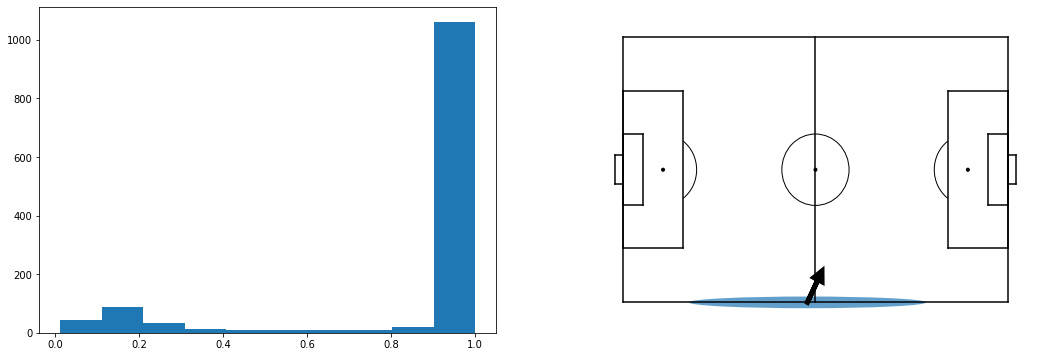

throw_in2


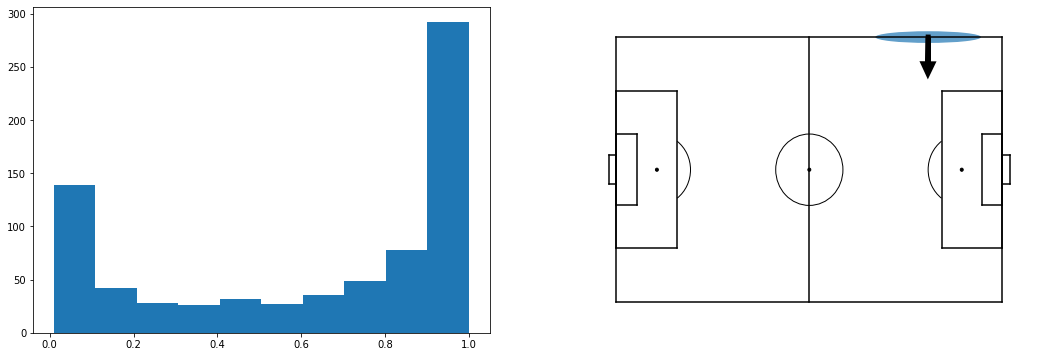

throw_in3


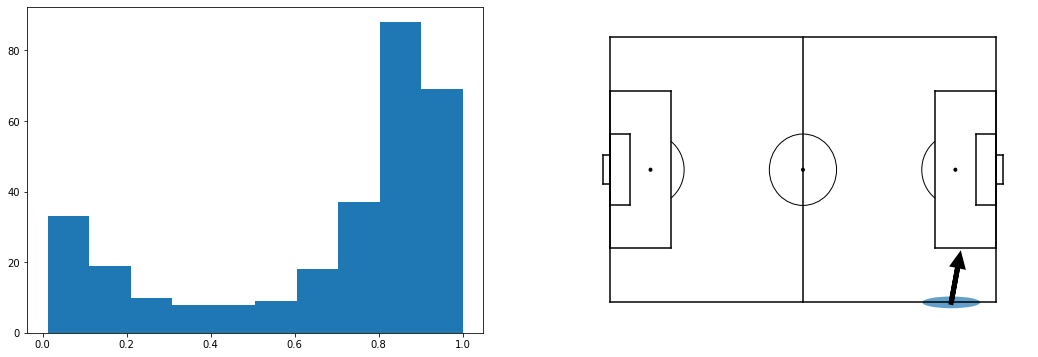

throw_in4


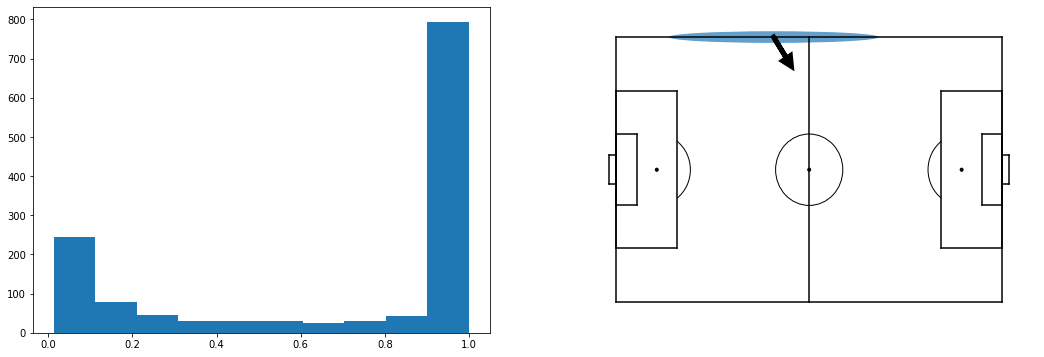

owngoal1


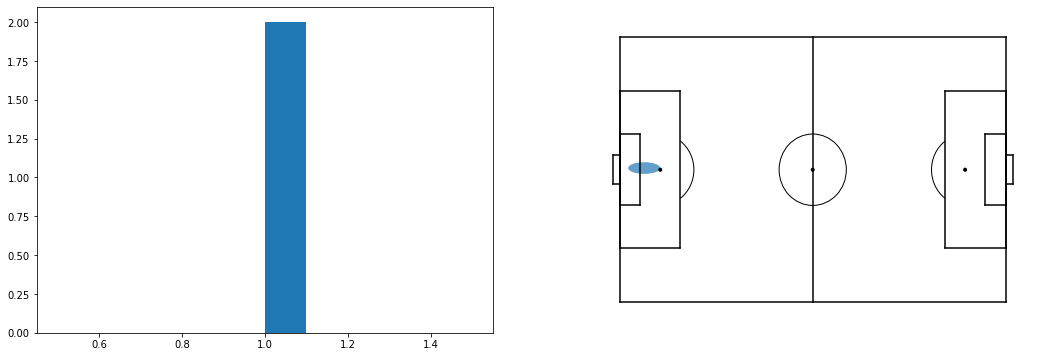

dribble1


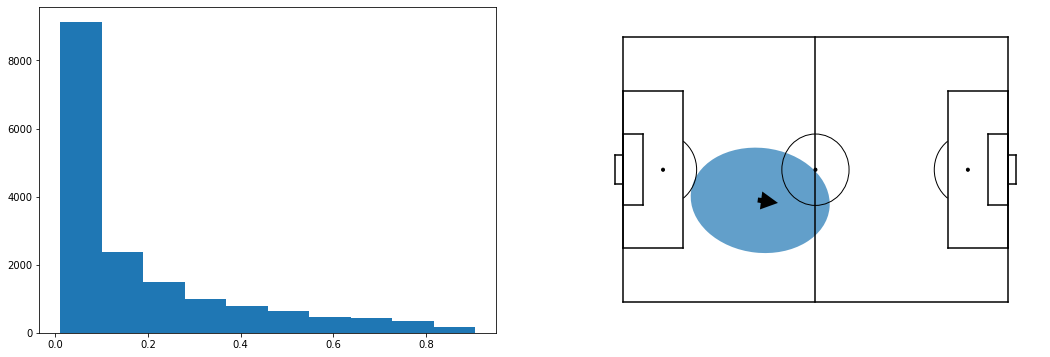

dribble2


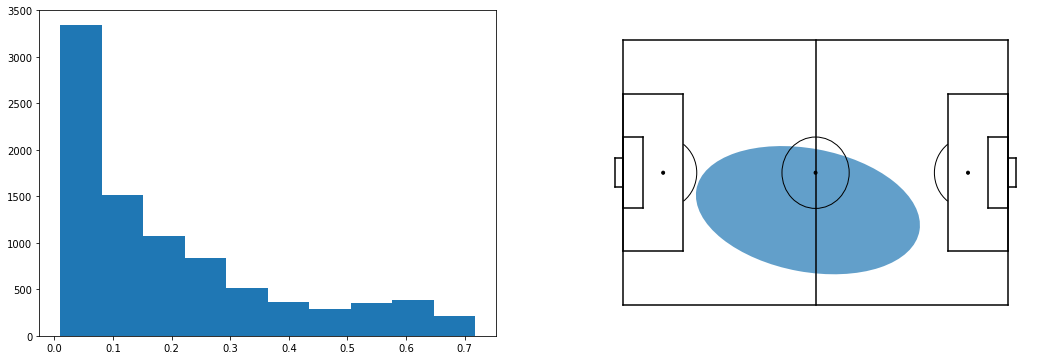

dribble3


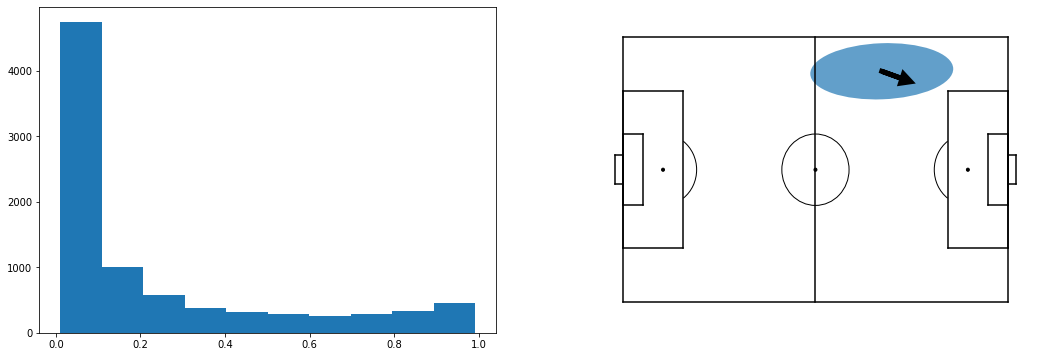

dribble4


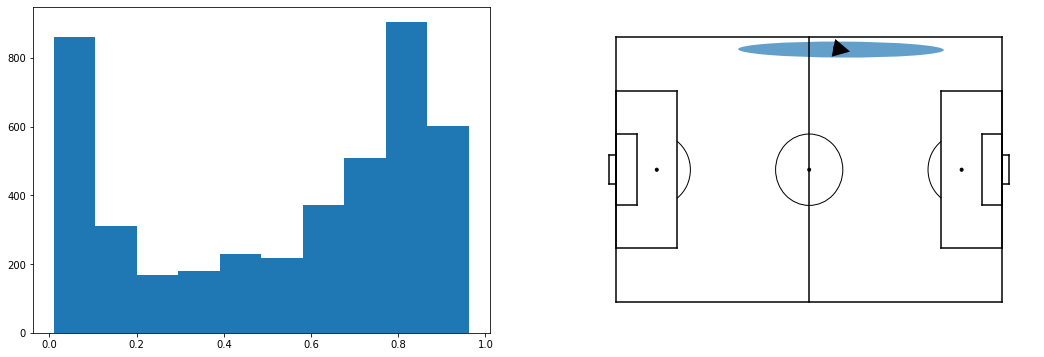

dribble5


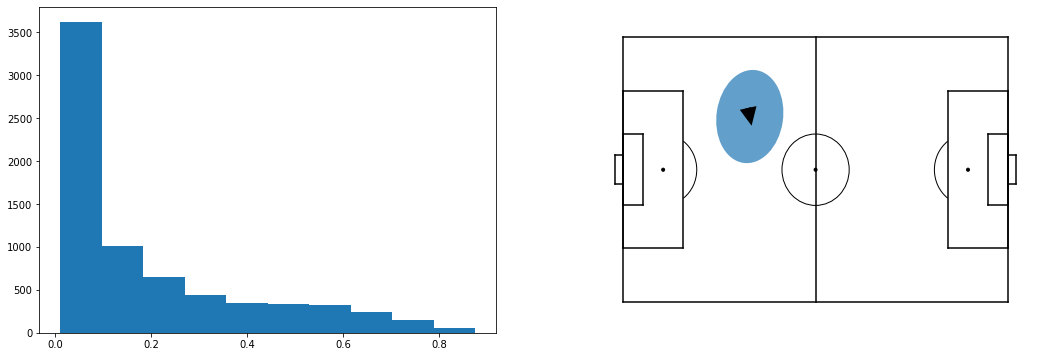

dribble6


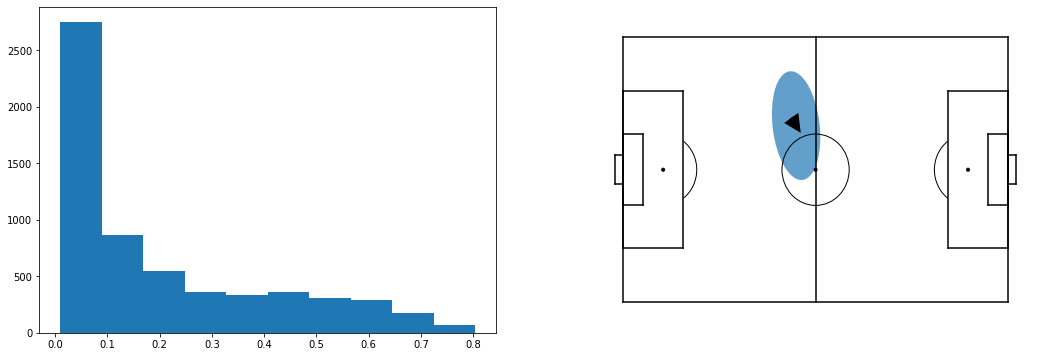

dribble7


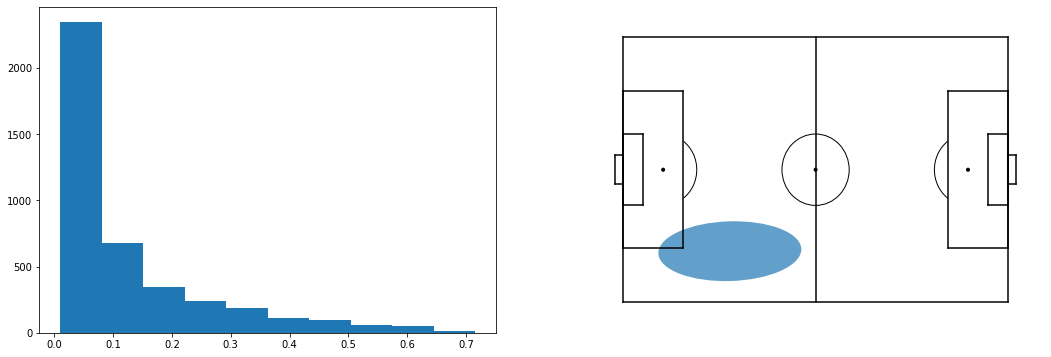

dribble8


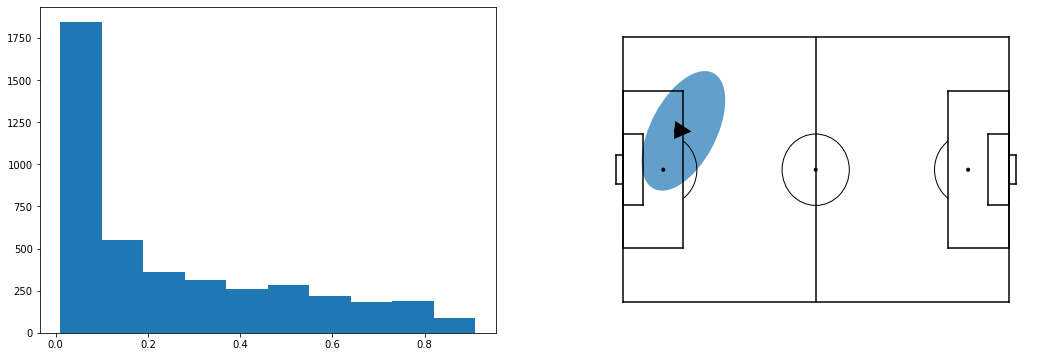

dribble9


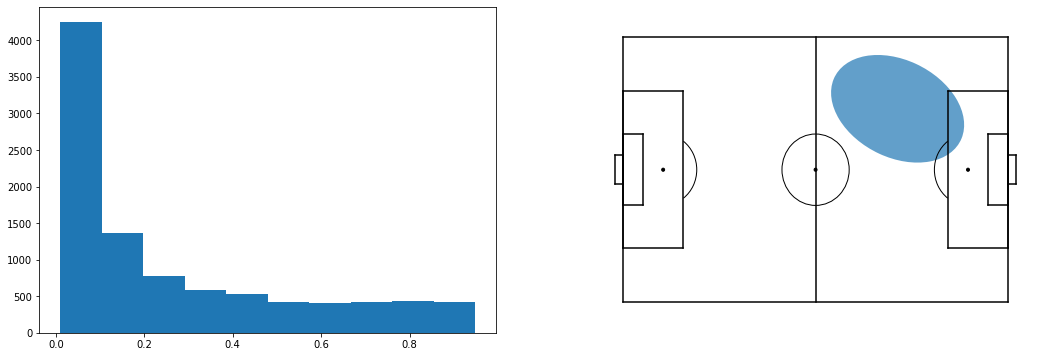

dribble10


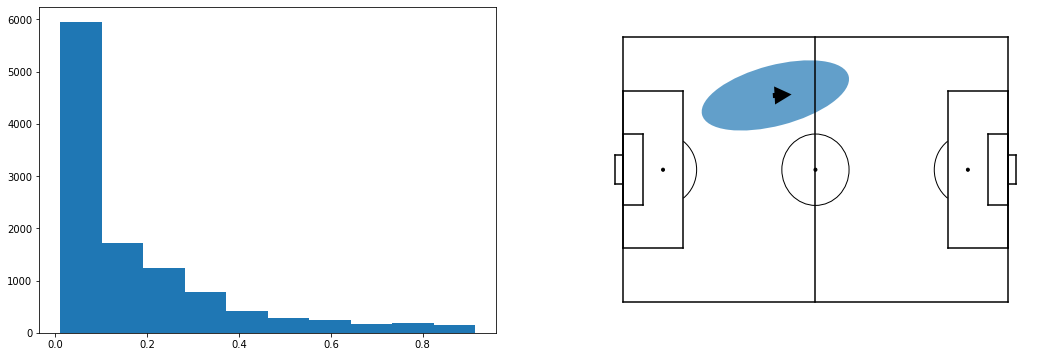

dribble11


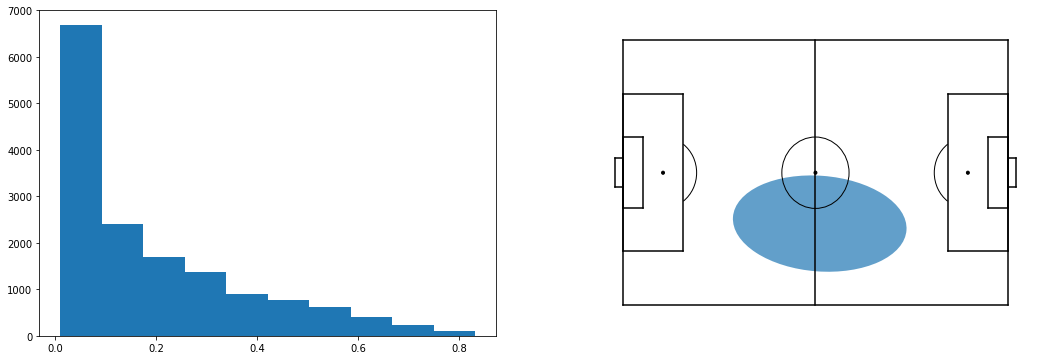

dribble12


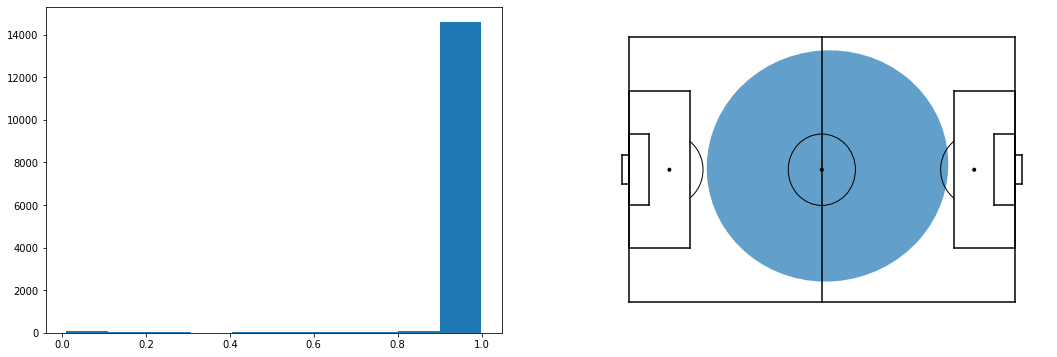

dribble13


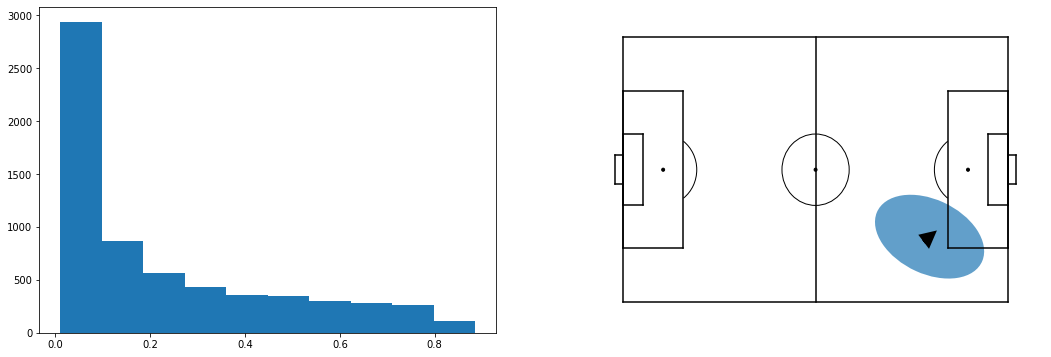

dribble14


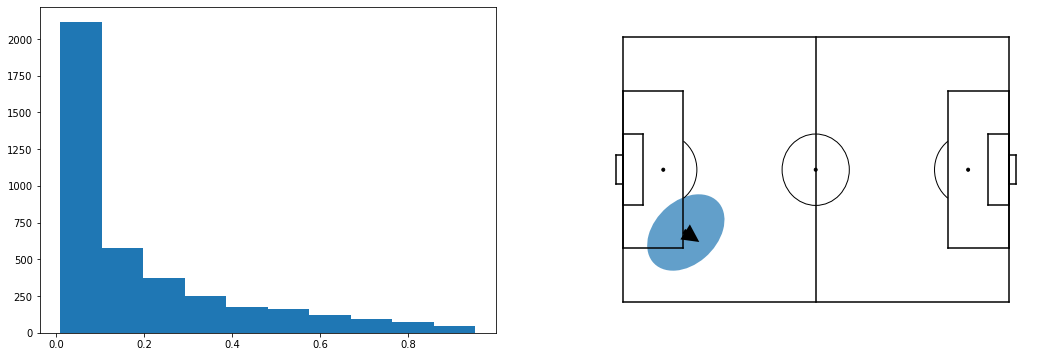

dribble15


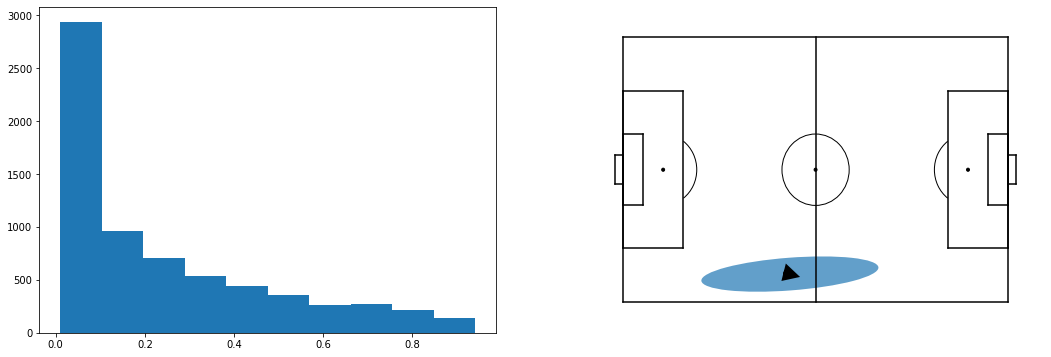

dribble16


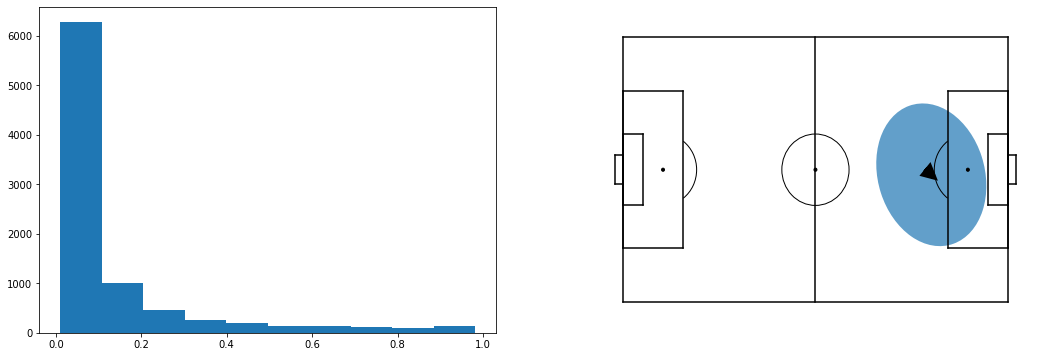

dribble17


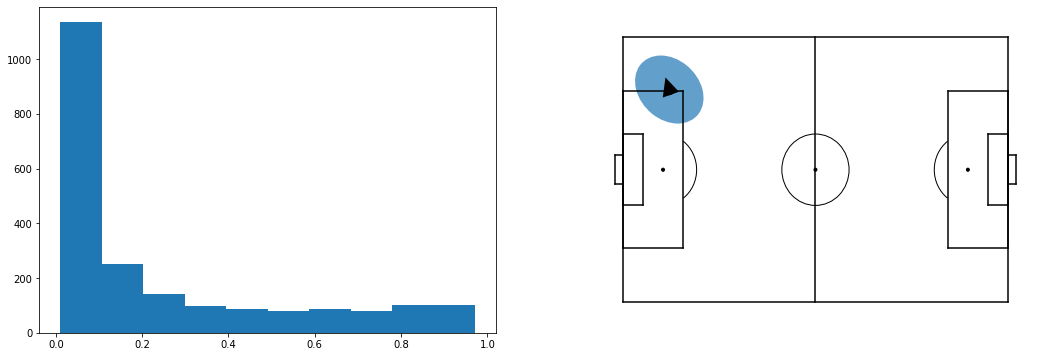

dribble18


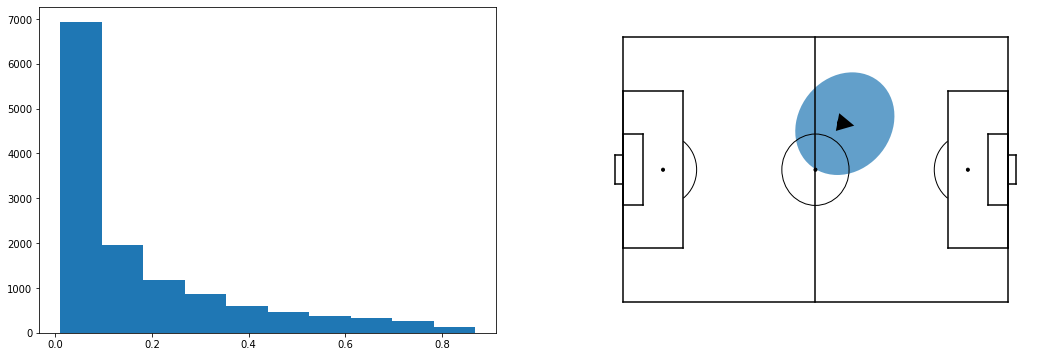

dribble19


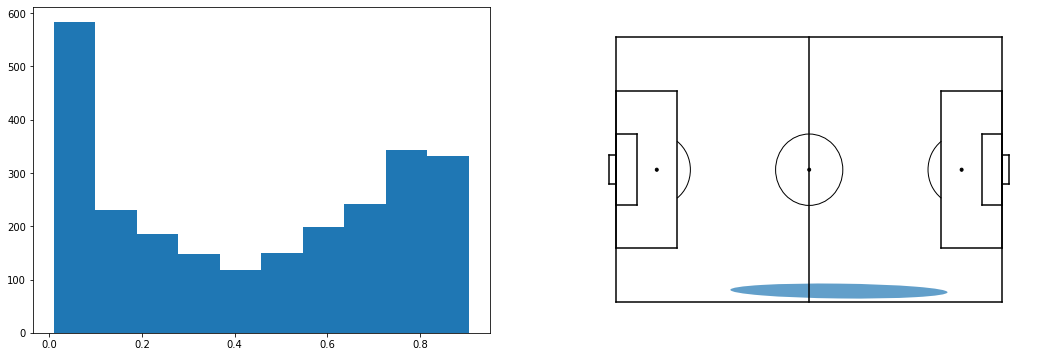

dribble20


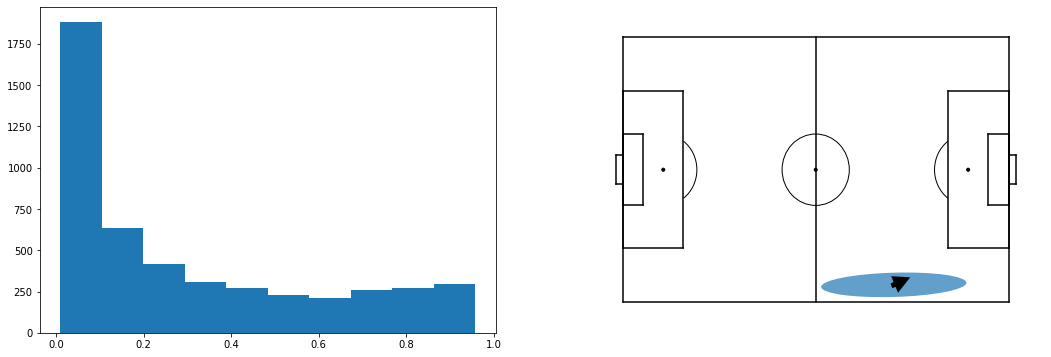

dribble21


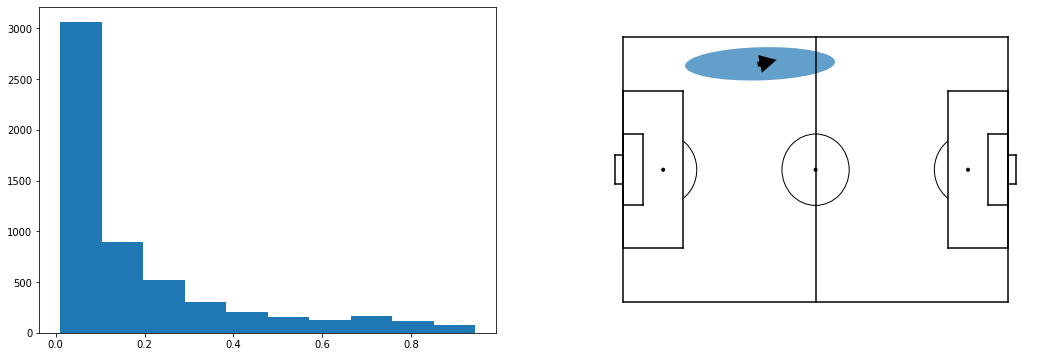

dribble22


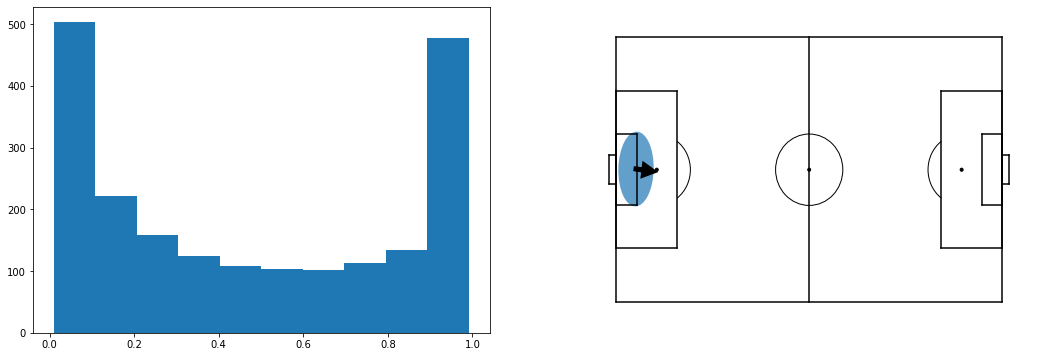

dribble23


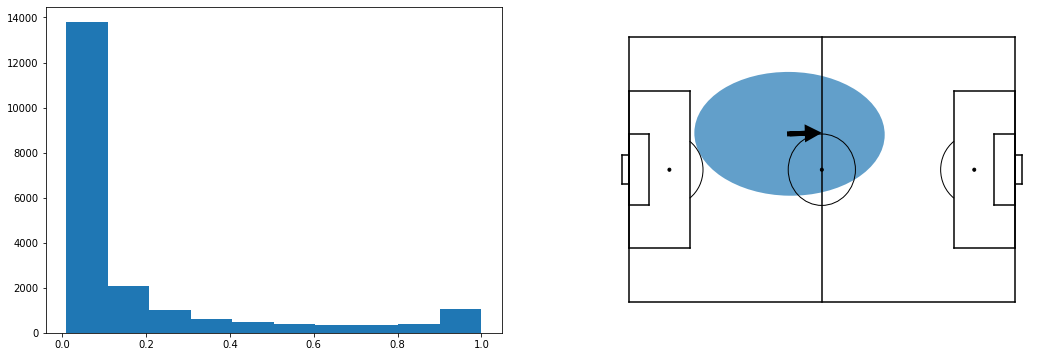

dribble24


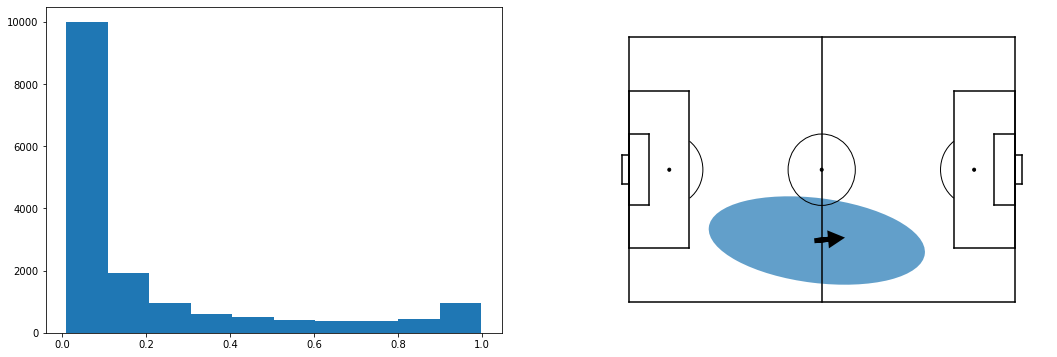

dribble25


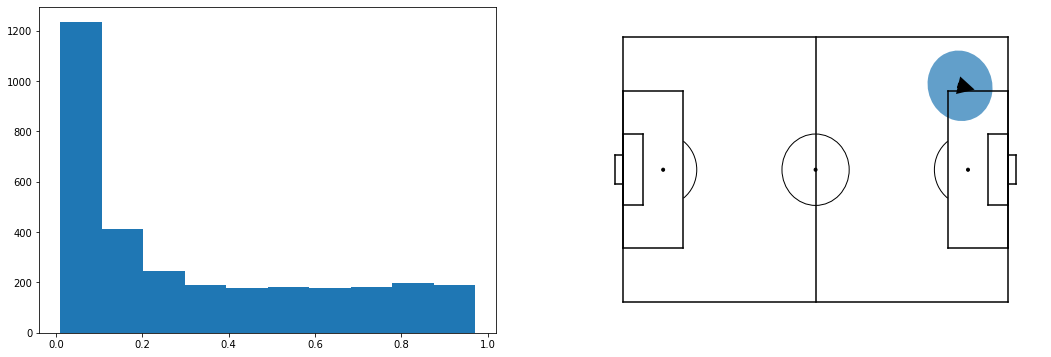

clearance1


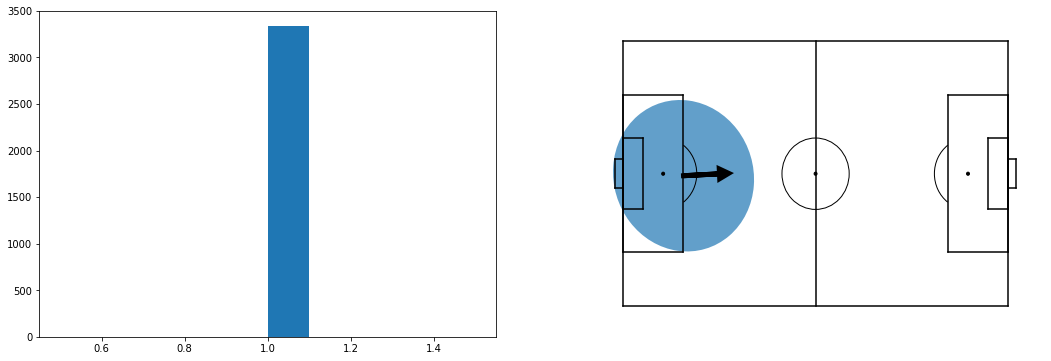

shot1


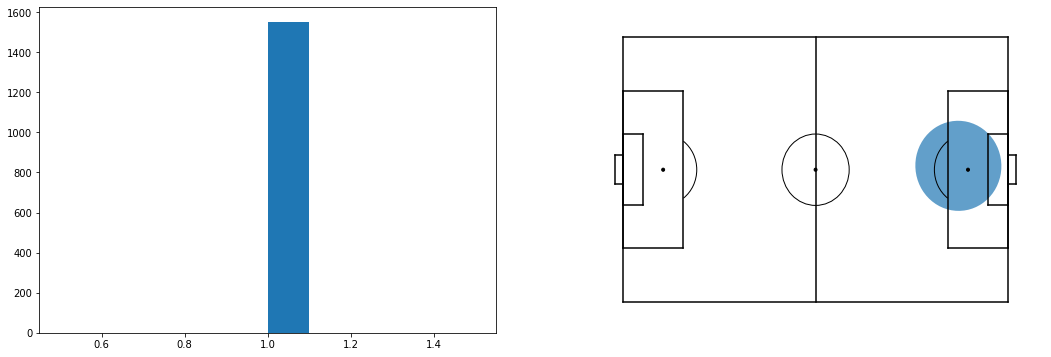

freekick1


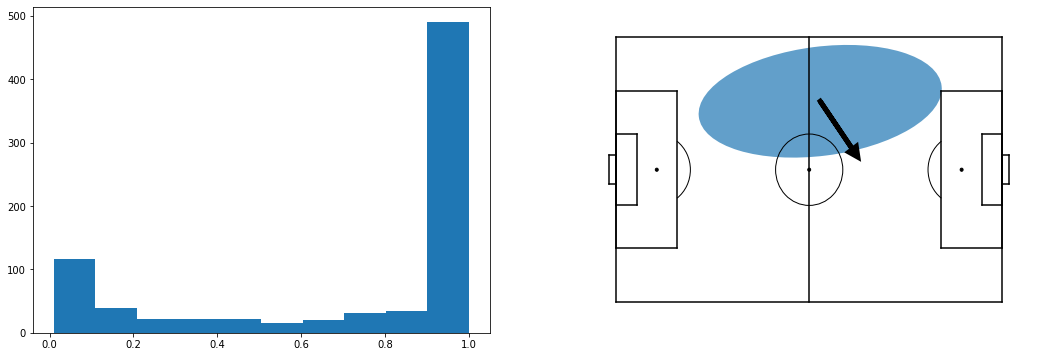

freekick2


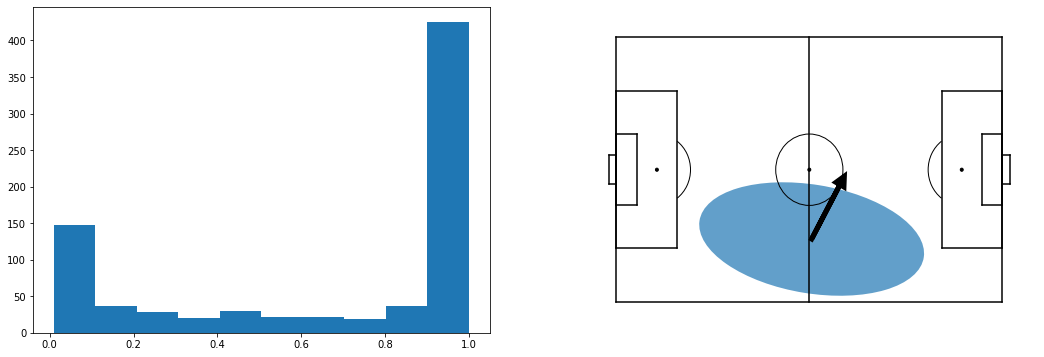

freekick3


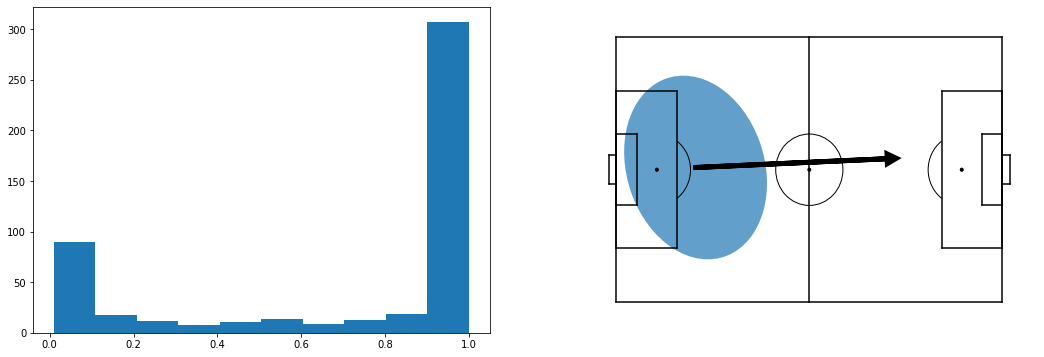

take_on1


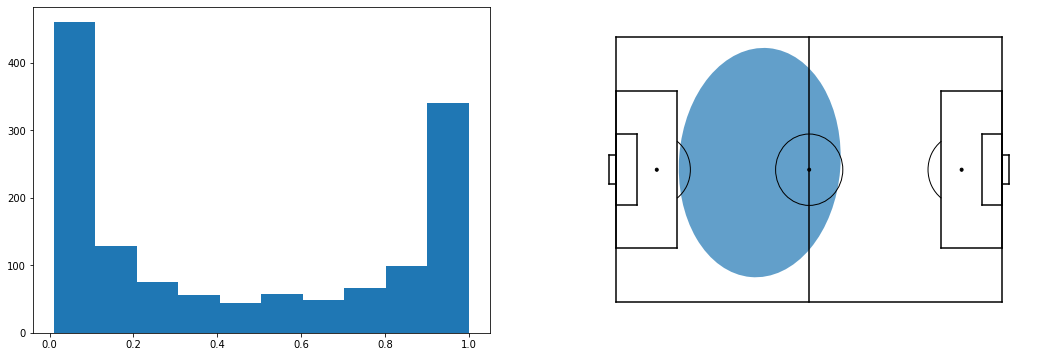

take_on2


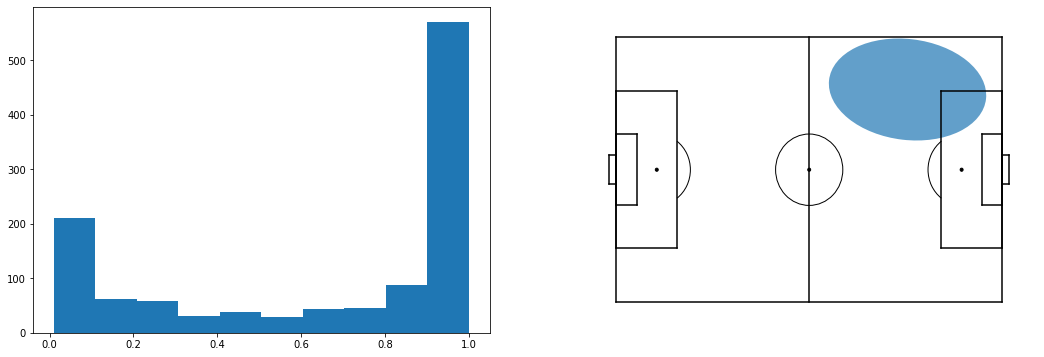

take_on3


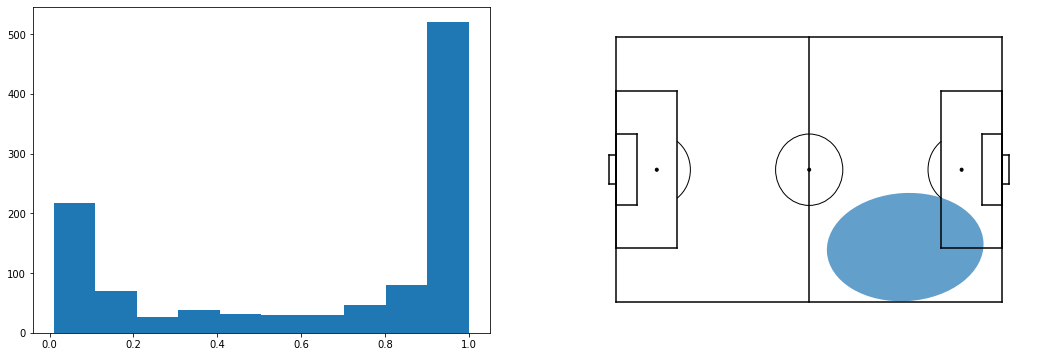

yellow_card1


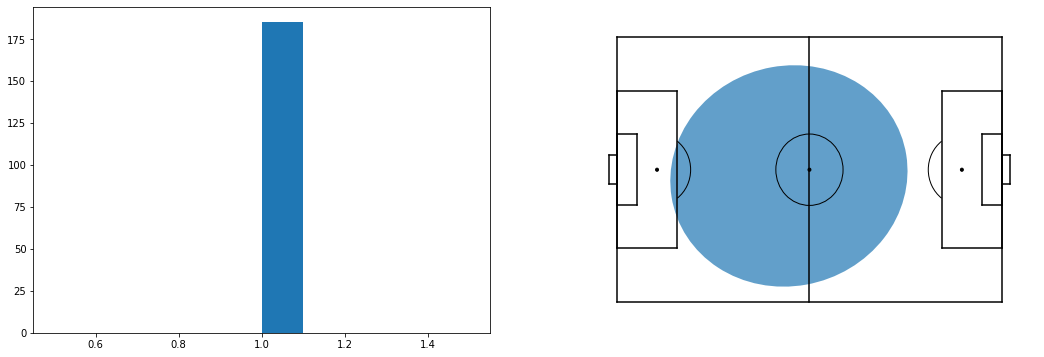

out1


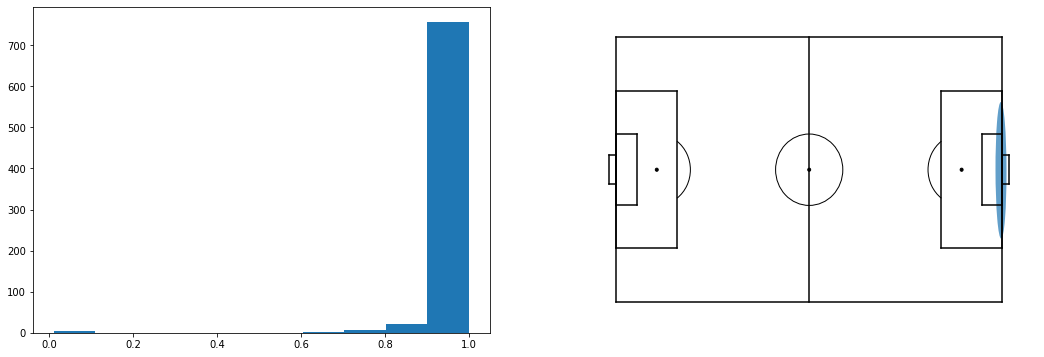

out2


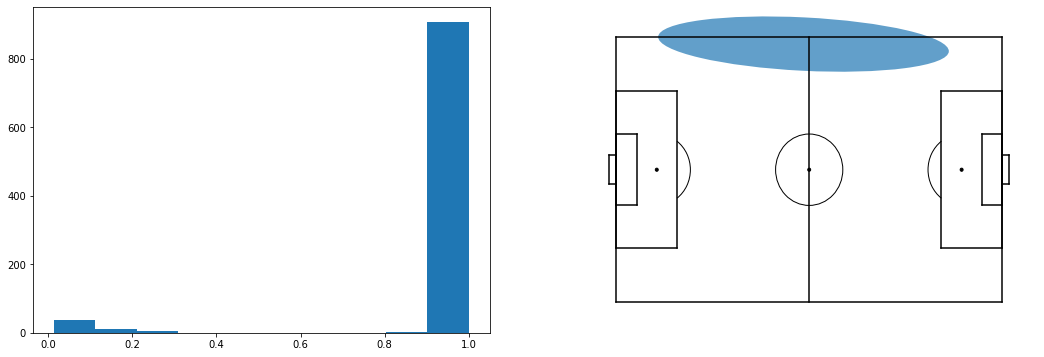

out3


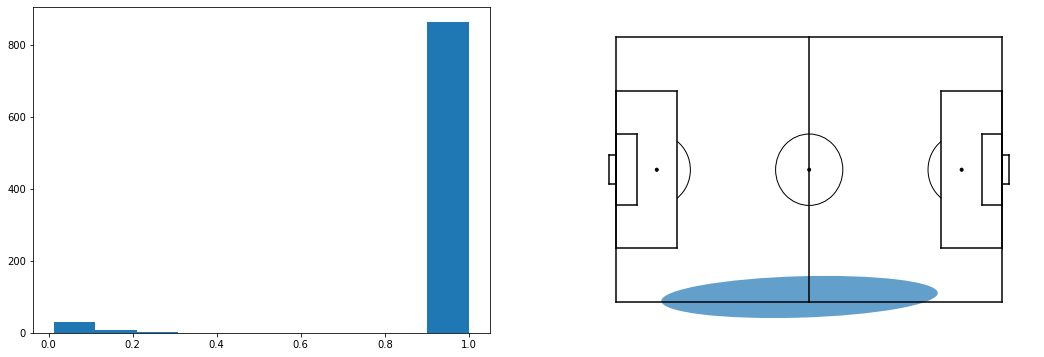

bad_touch1


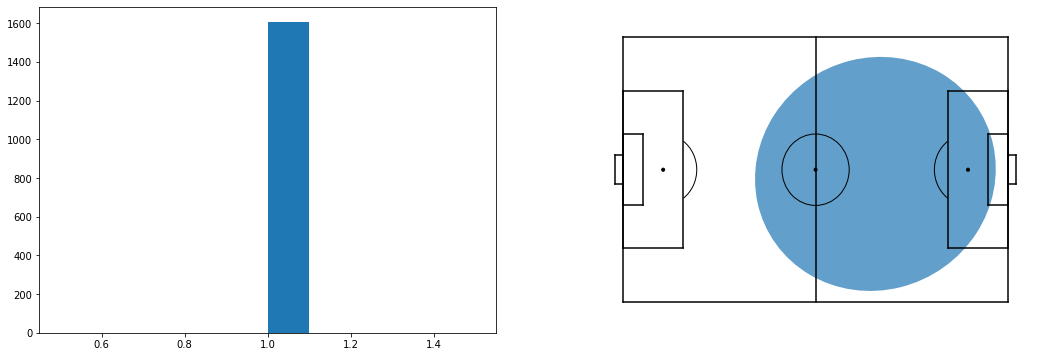

foul1


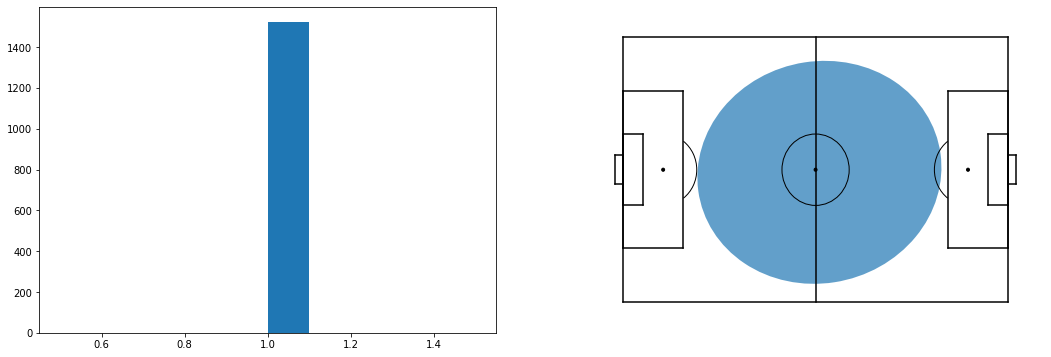

In [250]:
for ty in gmme.models:
    for k in range(gmme.models[ty].n_components):
        col = ty + str(k+1)
        print(col)
        v = probas[col].values
        
        fig,axs = plt.subplots(1,2)
        fig.set_size_inches(3*6,6)
        axs[0].hist(v[v>0.01])
        mps.field(ax=axs[1],show=False)
        vis.plot_component_w_arrow(gmme.models[ty],k,ax=axs[1])
        plt.show()

In [226]:
ucprobas = pat.uncouple_probabilities(probas,a.is_home.values)
ucprobas
ucprobas.values.sum()

199999.99999999994

(199999, 300)


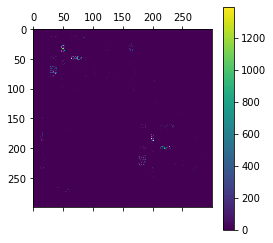

In [227]:
prev = ucprobas.values[:-1]
nex = ucprobas.values[1:]
print(prev.shape)
trans = np.dot(prev.T,nex)
plt.matshow(trans)
plt.colorbar()
plt.show()
trans /= trans.sum()
# for i in range(len(trans[0])):
#     trans[i,:] /= trans[i,:].sum()
trans.sum()
ori_trans = trans

In [228]:
trans1 = ori_trans.copy()
for _i in range(10):
    print(trans1.sum())
    trans1 = np.dot(ori_trans.T,trans1)
    trans1 /= trans1.sum()

1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999999
1.0


(0.0033171722813303776, -0.005156012927876239)

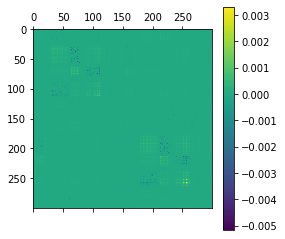

In [192]:
delta_trans = trans1 - ori_trans
plt.matshow(delta_trans)
plt.colorbar()
plt.show
delta_trans.max(), delta_trans.min()

In [194]:
trans = delta_trans
trans = trans1

In [195]:
trans.sum()

0.9999999999999998

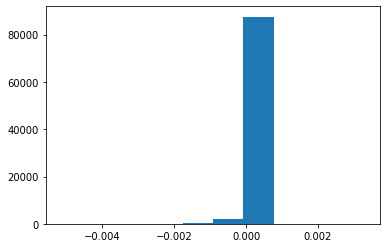

In [196]:
plt.hist([p for p,i,j in probs])
plt.show()

0.0069781590840436985 185 198
pass8_opp (red) -> receival2_opp (blue)


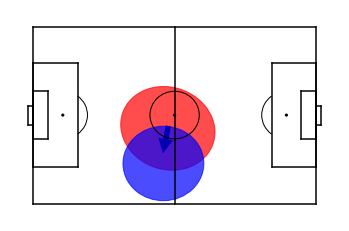

0.00667742411576694 30 49
pass3 (red) -> receival3 (blue)


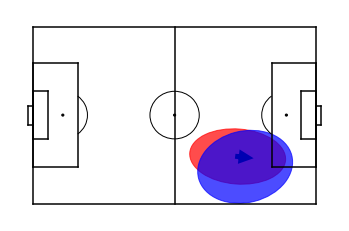

0.006641650623836523 188 201
pass11_opp (red) -> receival5_opp (blue)


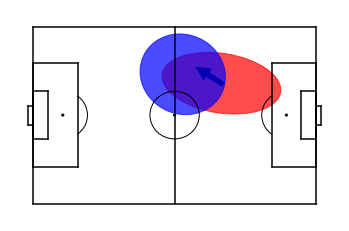

0.006524553380452912 35 48
pass8 (red) -> receival2 (blue)


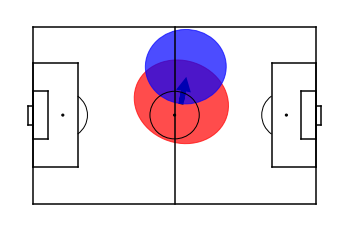

0.006399633782195139 38 51
pass11 (red) -> receival5 (blue)


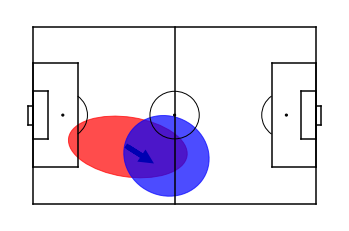

0.006378669137741659 178 202
pass1_opp (red) -> receival6_opp (blue)


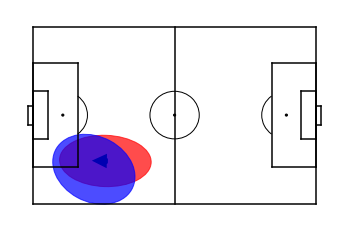

0.006351253370070112 180 199
pass3_opp (red) -> receival3_opp (blue)


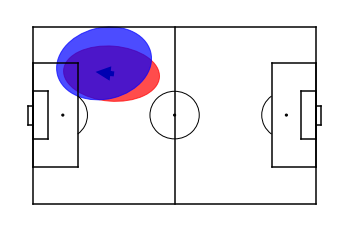

0.006196095569138215 51 64
receival5 (red) -> dribble2 (blue)


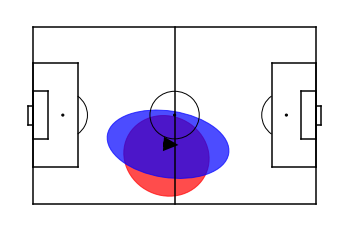

0.006148320745323112 201 214
receival5_opp (red) -> dribble2_opp (blue)


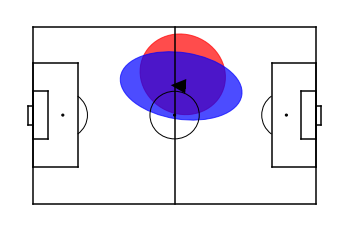

0.006022054962377374 37 48
pass10 (red) -> receival2 (blue)


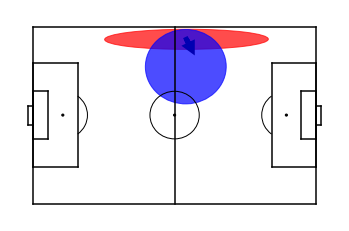

In [230]:
probs = []
for i in range(len(trans)):
    for j in range(len(trans)):
        probs.append((trans[i,j],i,j))
probs = sorted(probs,reverse=True)
movs = [(p,i,j) for p,i,j in probs]# if i != j]

cols = list(ucprobas.columns)

def test(i,j):
    return True
    return "goal1" in cols[j]# and "opp" not in cols[j]
    return "shot" in cols[i] and "opp" not in cols[j]

interestmovs = [(p,i,j) for p,i,j in movs 
                if test(i,j)
                #"pass" not in cols[i]
                   # and "receival" not in cols[i]
                   # and "dribble" not in cols[i]
               ]

for p,i,j in interestmovs[:10]:
    print(p,i,j)
    print(cols[i],"(red)","->",cols[j],"(blue)")
    ax = mps.field(show=False)
    ty,k = gmme._global_to_local(i % gmme.total_components())
    is_opp = i > gmme.total_components() - 1
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="red",mirror=is_opp,show=False)
    ty,k = gmme._global_to_local(j % gmme.total_components())
    is_opp = j > gmme.total_components() - 1
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="blue",mirror=is_opp,show=False)
    plt.show()

In [ ]:
labels = np.argmax(probas.values,axis=1)

for p,i,j in movs[:10000]:
    cols = gmme._columns()
    if "shot" in cols[j] and "kick" not in cols[j]:# or True:
        print(p,i,j)
        print(cols[i],"(blue)","->",cols[j],"(red)")
        l_idx = (labels == i) | (labels == j)
        twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
        axs = vis.locmovaxes()
        axs[0].scatter(a.x[l_idx],a.y[l_idx],color=twocolors)
        axs[1].scatter(a.dx[l_idx],a.dy[l_idx],color=twocolors)
        plt.show()
    if p < 50:
        break

In [ ]:
labels = np.argmax(probas.values,axis=1)

for p,i,j in movs[:10000]:
    cols = gmme._columns()
    if "shot" in cols[j] and "kick" not in cols[j]:# or True:
        print(p,i,j)
        print(cols[i],"(blue)","->",cols[j],"(red)")
        l_idx = (labels == i) | (labels == j)
        twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
        axs = vis.locmovaxes()
        axs[0].scatter(a.x[l_idx],a.y[l_idx],color=twocolors)
        axs[1].scatter(a.dx[l_idx],a.dy[l_idx],color=twocolors)
        plt.show()
    if p < 5:
        break